In [2]:
# Mixed new and old data

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, Conv2DTranspose
#from keras.utils.vis_utils import plot_model
import keras.backend as K
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import numpy as np
import random
from tensorflow.keras.models import load_model
# Set the random seeds for reproducibility
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)



# Mixed new and old data

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, Conv2DTranspose
#from keras.utils.vis_utils import plot_model
import keras.backend as K
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import numpy as np
import random
from tensorflow.keras.models import load_model
# Set the random seeds for reproducibility
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)



import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.models import Model

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.models import Model

def build_unet(input_shape, input_shape2, seed_value=42):
    # Define inputs
    input_low_geometry = Input(shape=input_shape, name='low_geometry_input')
    input_low_stream = Input(shape=input_shape2, name='low_stream_input')
    input_low_pressure = Input(shape=input_shape2, name='low_pressure_input')

    # First Half U-Net (Input: X_lg, X_lv)
    concat1 = concatenate([input_low_geometry, input_low_stream], axis=-1)

    conv1_1 = Conv2D(64, 3, activation='relu', padding='same')(concat1)
    conv1_1 = Conv2D(64, 3, activation='relu', padding='same')(conv1_1)
    pool1_1 = MaxPooling2D(pool_size=(2, 2))(conv1_1)

    conv2_1 = Conv2D(128, 3, activation='relu', padding='same')(pool1_1)
    conv2_1 = Conv2D(128, 3, activation='relu', padding='same')(conv2_1)
    pool2_1 = MaxPooling2D(pool_size=(2, 2))(conv2_1)

    conv3_1 = Conv2D(256, 3, activation='relu', padding='same')(pool2_1)
    conv3_1 = Conv2D(256, 3, activation='relu', padding='same')(conv3_1)
    pool3_1 = MaxPooling2D(pool_size=(2, 2))(conv3_1)

    # Second Half U-Net (Input: X_lg, X_lp)
    concat2 = concatenate([input_low_geometry, input_low_pressure], axis=-1)

    conv1_2 = Conv2D(64, 3, activation='relu', padding='same')(concat2)
    conv1_2 = Conv2D(64, 3, activation='relu', padding='same')(conv1_2)
    pool1_2 = MaxPooling2D(pool_size=(2, 2))(conv1_2)

    conv2_2 = Conv2D(128, 3, activation='relu', padding='same')(pool1_2)
    conv2_2 = Conv2D(128, 3, activation='relu', padding='same')(conv2_2)
    pool2_2 = MaxPooling2D(pool_size=(2, 2))(conv2_2)

    conv3_2 = Conv2D(256, 3, activation='relu', padding='same')(pool2_2)
    conv3_2 = Conv2D(256, 3, activation='relu', padding='same')(conv3_2)
    pool3_2 = MaxPooling2D(pool_size=(2, 2))(conv3_2)

    # Concatenate outputs of two half U-Nets (same resolution)
    combined = concatenate([pool3_1, pool3_2], axis=-1)

    # Full U-Net (takes combined outputs as input)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(combined)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    # Expanding path
    up6 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(conv5)
    up6 = concatenate([up6, conv4])
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up7, conv3_1, conv3_2])  # Use original feature maps from both half U-Nets
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    up8 = concatenate([up8, conv2_1, conv2_2])
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    up9 = concatenate([up9, conv1_1, conv1_2])
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    # Velocity output layer
    velocity_outputs = Conv2D(1, 1, activation='sigmoid', name='velocity_output')(conv9)

    # Pressure output layer
    pressure_outputs = Conv2D(1, 1, activation='sigmoid', name='pressure_output')(conv9)

    model = Model(inputs=[input_low_geometry, input_low_stream, input_low_pressure], outputs=[pressure_outputs, velocity_outputs])

    return model


def boundary_loss(y_true, y_pred):
    # Extract velocity and pressure from predictions and true values
    velocity_pred = y_pred[0]
    pressure_pred = y_pred[1]
    velocity_true = y_true[0]
    pressure_true = y_true[1]
    
    # Compute max and min values for velocity and pressure
    velocity_pred_max = tf.reduce_max(velocity_pred)
    velocity_pred_min = tf.reduce_min(velocity_pred)
    velocity_true_max = tf.reduce_max(velocity_true)
    velocity_true_min = tf.reduce_min(velocity_true)
    
    pressure_pred_max = tf.reduce_max(pressure_pred)
    pressure_pred_min = tf.reduce_min(pressure_pred)
    pressure_true_max = tf.reduce_max(pressure_true)
    pressure_true_min = tf.reduce_min(pressure_true)
    
    # Compute residuals for max and min values
    velocity_residual = tf.square(velocity_pred_max - velocity_true_max) + tf.square(velocity_pred_min - velocity_true_min)
    pressure_residual = tf.square(pressure_pred_max - pressure_true_max) + tf.square(pressure_pred_min - pressure_true_min)
    
    # Total loss as the sum of residuals
    tloss = (velocity_residual + pressure_residual)/2
    
    return tloss





def physical_loss(y_true, y_pred):
    
   
    # Extract velocity and pressure from predictions and true values
    velocity_pred = y_pred[0]
    pressure_pred = y_pred[1]
    velocity_true = y_true[0]
    pressure_true = y_true[1]
    
    
    # Convert the numpy array to a TensorFlow tensor
    velocity_true = tf.convert_to_tensor(velocity_true, dtype=tf.float32)
    pressure_true = tf.convert_to_tensor(pressure_true, dtype=tf.float32)
    
    
    
    velocity_true = tf.expand_dims(velocity_true, axis=-1)
    pressure_true = tf.expand_dims(pressure_true, axis=-1)
    
    velocity_true = tf.expand_dims(velocity_true, axis=0)
    pressure_true = tf.expand_dims(pressure_true, axis=0)
    
    
    velocity_pred = tf.expand_dims(velocity_pred, axis=-1)
    pressure_pred = tf.expand_dims(pressure_pred, axis=-1)

    velocity_pred = tf.expand_dims(velocity_pred, axis=0)
    pressure_pred = tf.expand_dims(pressure_pred, axis=0)

    

    # Compute gradients
    velocity_gradients_pred = tf.image.image_gradients(velocity_pred)
    pressure_gradients_pred = tf.image.image_gradients(pressure_pred)
    velocity_gradients_true = tf.image.image_gradients(velocity_true)
    pressure_gradients_true = tf.image.image_gradients(pressure_true)

    # Compute divergence of velocity (for continuity equation)
    divergence_velocity_pred = velocity_gradients_pred[0] + velocity_gradients_pred[1]
    divergence_velocity_true = velocity_gradients_true[0] + velocity_gradients_true[1]
    
    divergence_pressure_pred = pressure_gradients_pred[0]+ pressure_gradients_pred[1]
    divergence_pressure_true = pressure_gradients_true[0] + pressure_gradients_true[1]


    # Compute the convective term (u · ∇)u for predicted and true velocity
    convective_term_pred = (
        velocity_pred[0] * velocity_gradients_pred[0] + 
        velocity_pred[0] * velocity_gradients_pred[1]
    )
    convective_term_true = (
        velocity_true[0] * velocity_gradients_true[0] + 
        velocity_true[0] * velocity_gradients_true[1]
    )

    # Compute the viscous term μ∇²u (Laplacian of velocity) for predicted and true velocity
    viscous_term_pred =  (
        tf.image.image_gradients(velocity_gradients_pred[0]) + 
        tf.image.image_gradients(velocity_gradients_pred[1])
    )
    viscous_term_true =  (
        tf.image.image_gradients(velocity_gradients_true[0]) + 
        tf.image.image_gradients(velocity_gradients_true[1])
    )

    # Compute the pressure gradient term ∇p for predicted and true pressure
    pressure_gradient_pred = tf.concat(pressure_gradients_pred, axis=-1)
    pressure_gradient_true = tf.concat(pressure_gradients_true, axis=-1)

    # Compute the momentum residual for predicted and true values
    momentum_residual_pred = (
        convective_term_pred - 
        pressure_gradient_pred + 
        viscous_term_pred
    )
    momentum_residual_true = (
        convective_term_true - 
        pressure_gradient_true + 
        viscous_term_true
    )
    
    
    

    # Compute the L2 norm of the momentum residual
    momentum_residual_norm = tf.reduce_mean(tf.square(momentum_residual_pred - momentum_residual_true))

    # Compute the L2 norm of the continuity residual
    continuity_residual_norm = tf.reduce_mean(tf.square(divergence_velocity_pred - divergence_velocity_true))

    # Total physical loss is the sum of momentum and continuity residuals
    physical_loss_value = 0.2*momentum_residual_norm +continuity_residual_norm

    return physical_loss_value

    
    



def total_loss(y_true, y_pred):
    # You can customize the weighting of the data loss and physical loss here
    weight_boundary_loss = 0.001
    weight_physical_loss = 0.999
    phy=physical_loss(y_true, y_pred)

    # Calculate the total loss as a combination of Boundary loss and physical loss
    total_loss = (weight_boundary_loss * boundary_loss(y_true, y_pred) )+(weight_physical_loss * phy )
    return total_loss
     






# Train the model with your dataset
import os
import numpy as np
from PIL import Image
from keras.callbacks import ModelCheckpoint


lv_folder = 'Low/LVV-new'
hv_folder = 'High/HVV'
lp_folder = 'Low/LPP-new'
hp_folder = 'High/HPP'
lg_folder = 'LG-3C'


# Get the list of file names in each folder
lv_files = [f for f in os.listdir(lv_folder) if f != ".ipynb_checkpoints"]
hv_files = [f for f in os.listdir(hv_folder) if f != ".ipynb_checkpoints"]
lp_files = [f for f in os.listdir(lp_folder) if f != ".ipynb_checkpoints"]
hp_files = [f for f in os.listdir(hp_folder) if f != ".ipynb_checkpoints"]
lg_files = [f for f in os.listdir(lg_folder) if f != ".ipynb_checkpoints"]

# Sort the file names to ensure the order is consistent
lv_files.sort()
hv_files.sort()
lp_files.sort()
hp_files.sort()
lg_files.sort()


# Set the input shape
input_shape = (256, 256, 3)  # Update to 3 channels for color images
input_shape2 = (256, 256, 1)

# Create empty lists to store the data
X_lv = []
X_lp = []
X_lg = []
Y_hv = []
Y_hp = []

# Read the data from the folders
for lv_file, hv_file,lp_file,hp_file,lg_file in zip(lv_files, hv_files,lp_files,hp_files,lg_files):
    try:
        
        # Read the channel geometry image
        lv_image = np.load(os.path.join(lv_folder, lv_file))  # Convert to RGB
        X_lv.append(np.array(lv_image))
        
        # Read the LFV
        hv_image = np.load(os.path.join(hv_folder, hv_file))  # Convert to RGB
        Y_hv.append(np.array(hv_image))

        # Read the LFP
        lp_image = np.load(os.path.join(lp_folder, lp_file))  # Convert to RGB
        X_lp.append(np.array(lp_image))
    
    
        # Read the channel geometry image
        lg_image = Image.open(os.path.join(lg_folder, lg_file)).convert('RGB')  # Convert to RGB
        lg_image = lg_image.resize(input_shape[:2])  # Resize the image
        X_lg.append(np.array(lg_image))
    
        # Read the HFP
        hp_image = np.load(os.path.join(hp_folder, hp_file))  # Convert to RGB
        Y_hp.append(np.array(hp_image))
    except:
        print('')

# Convert the lists to arrays
X_lv = np.array(X_lv) 
X_lp = np.array(X_lp) 
X_lg = np.array(X_lg) / 255.0  # Normalize the channel geometry images
Y_hv = np.array(Y_hv)
Y_hp = np.array(Y_hp)

Y_hpt=(Y_hp-np.min(Y_hp))/(np.max(Y_hp)-np.min(Y_hp))
X_lpt=(X_lp-np.min(X_lp))/(np.max(X_lp)-np.min(X_lp))


# Build the U-Net model
model = build_unet(input_shape,input_shape2)

X_lpt[np.isnan(X_lpt)] = 0
X_lv[np.isnan(X_lv)] = 0
Y_hpt[np.isnan(Y_hpt)] = 0
Y_hv[np.isnan(Y_hv)] = 0

optim = Adam(learning_rate=0.00001)
# Compile the model with the desired loss functions
model.compile(optimizer=optim,
              loss=[total_loss,total_loss])
# Set up checkpoints to save the best model during training
checkpoint_path = 'Saved_Models_Temp/Micro-Unet-3-Inputs.h5'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# Train the model
epochs = 2400
batch_size = 16
print('start fitting')
model.fit([X_lg,X_lv,X_lpt], [Y_hpt, Y_hv],
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2,
          callbacks=[checkpoint])







start fitting
Epoch 1/2400


2025-03-14 01:30:19.243450: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


142/142 [==============================] - ETA: 0s - loss: 0.0010 - pressure_output_loss: 4.4230e-04 - velocity_output_loss: 5.8068e-04

2025-03-14 01:32:01.103627: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.00066, saving model to Saved_Models/Micro-Unet-3-Inputs.h5
142/142 [==============================] - 111s 771ms/step - loss: 0.0010 - pressure_output_loss: 4.4230e-04 - velocity_output_loss: 5.8068e-04 - val_loss: 6.5607e-04 - val_pressure_output_loss: 2.5283e-04 - val_velocity_output_loss: 4.0324e-04
Epoch 2/2400
142/142 [==============================] - ETA: 0s - loss: 8.3729e-04 - pressure_output_loss: 3.3698e-04 - velocity_output_loss: 5.0031e-04
Epoch 2: val_loss improved from 0.00066 to 0.00062, saving model to Saved_Models/Micro-Unet-3-Inputs.h5
142/142 [==============================] - 107s 751ms/step - loss: 8.3729e-04 - pressure_output_loss: 3.3698e-04 - velocity_output_loss: 5.0031e-04 - val_loss: 6.2382e-04 - val_pressure_output_loss: 2.5564e-04 - val_velocity_output_loss: 3.6819e-04
Epoch 3/2400
142/142 [==============================] - ETA: 0s - loss: 7.2632e-04 - pressure_output_loss: 2.8181e-04 - velocity_output_loss: 4.4451

142/142 [==============================] - 110s 775ms/step - loss: 3.6418e-04 - pressure_output_loss: 7.8238e-05 - velocity_output_loss: 2.8594e-04 - val_loss: 1.5224e-04 - val_pressure_output_loss: 6.5838e-05 - val_velocity_output_loss: 8.6400e-05
Epoch 18/2400
142/142 [==============================] - ETA: 0s - loss: 3.1747e-04 - pressure_output_loss: 5.6735e-05 - velocity_output_loss: 2.6074e-04
Epoch 18: val_loss improved from 0.00015 to 0.00014, saving model to Saved_Models/Micro-Unet-3-Inputs.h5
142/142 [==============================] - 111s 781ms/step - loss: 3.1747e-04 - pressure_output_loss: 5.6735e-05 - velocity_output_loss: 2.6074e-04 - val_loss: 1.3891e-04 - val_pressure_output_loss: 5.8457e-05 - val_velocity_output_loss: 8.0456e-05
Epoch 19/2400
142/142 [==============================] - ETA: 0s - loss: 3.1464e-04 - pressure_output_loss: 5.5784e-05 - velocity_output_loss: 2.5886e-04
Epoch 19: val_loss improved from 0.00014 to 0.00013, saving model to Saved_Models/Micro-U

Epoch 34/2400
142/142 [==============================] - ETA: 0s - loss: 3.1802e-04 - pressure_output_loss: 4.6980e-05 - velocity_output_loss: 2.7104e-04
Epoch 34: val_loss did not improve from 0.00009
142/142 [==============================] - 110s 773ms/step - loss: 3.1802e-04 - pressure_output_loss: 4.6980e-05 - velocity_output_loss: 2.7104e-04 - val_loss: 9.1723e-05 - val_pressure_output_loss: 2.8527e-05 - val_velocity_output_loss: 6.3196e-05
Epoch 35/2400
142/142 [==============================] - ETA: 0s - loss: 3.1322e-04 - pressure_output_loss: 4.7122e-05 - velocity_output_loss: 2.6610e-04
Epoch 35: val_loss improved from 0.00009 to 0.00009, saving model to Saved_Models/Micro-Unet-3-Inputs.h5
142/142 [==============================] - 110s 777ms/step - loss: 3.1322e-04 - pressure_output_loss: 4.7122e-05 - velocity_output_loss: 2.6610e-04 - val_loss: 8.6114e-05 - val_pressure_output_loss: 2.5536e-05 - val_velocity_output_loss: 6.0578e-05
Epoch 36/2400
142/142 [==================

142/142 [==============================] - ETA: 0s - loss: 2.7351e-04 - pressure_output_loss: 3.7598e-05 - velocity_output_loss: 2.3591e-04
Epoch 51: val_loss did not improve from 0.00006
142/142 [==============================] - 111s 783ms/step - loss: 2.7351e-04 - pressure_output_loss: 3.7598e-05 - velocity_output_loss: 2.3591e-04 - val_loss: 6.3349e-05 - val_pressure_output_loss: 1.3674e-05 - val_velocity_output_loss: 4.9675e-05
Epoch 52/2400
142/142 [==============================] - ETA: 0s - loss: 2.8256e-04 - pressure_output_loss: 3.8888e-05 - velocity_output_loss: 2.4368e-04
Epoch 52: val_loss improved from 0.00006 to 0.00006, saving model to Saved_Models/Micro-Unet-3-Inputs.h5
142/142 [==============================] - 114s 803ms/step - loss: 2.8256e-04 - pressure_output_loss: 3.8888e-05 - velocity_output_loss: 2.4368e-04 - val_loss: 6.0678e-05 - val_pressure_output_loss: 1.3303e-05 - val_velocity_output_loss: 4.7375e-05
Epoch 53/2400
142/142 [==============================] 

142/142 [==============================] - ETA: 0s - loss: 2.5252e-04 - pressure_output_loss: 3.5897e-05 - velocity_output_loss: 2.1662e-04
Epoch 85: val_loss improved from 0.00004 to 0.00004, saving model to Saved_Models/Micro-Unet-3-Inputs.h5
142/142 [==============================] - 109s 766ms/step - loss: 2.5252e-04 - pressure_output_loss: 3.5897e-05 - velocity_output_loss: 2.1662e-04 - val_loss: 4.4314e-05 - val_pressure_output_loss: 7.1803e-06 - val_velocity_output_loss: 3.7133e-05
Epoch 86/2400
142/142 [==============================] - ETA: 0s - loss: 2.5241e-04 - pressure_output_loss: 3.3408e-05 - velocity_output_loss: 2.1900e-04
Epoch 86: val_loss did not improve from 0.00004
142/142 [==============================] - 109s 764ms/step - loss: 2.5241e-04 - pressure_output_loss: 3.3408e-05 - velocity_output_loss: 2.1900e-04 - val_loss: 4.5561e-05 - val_pressure_output_loss: 9.0606e-06 - val_velocity_output_loss: 3.6501e-05
Epoch 87/2400
142/142 [==============================] 

Epoch 120/2400
142/142 [==============================] - ETA: 0s - loss: 2.2988e-04 - pressure_output_loss: 2.9047e-05 - velocity_output_loss: 2.0083e-04
Epoch 120: val_loss did not improve from 0.00004
142/142 [==============================] - 109s 771ms/step - loss: 2.2988e-04 - pressure_output_loss: 2.9047e-05 - velocity_output_loss: 2.0083e-04 - val_loss: 4.0645e-05 - val_pressure_output_loss: 6.9292e-06 - val_velocity_output_loss: 3.3716e-05
Epoch 121/2400
142/142 [==============================] - ETA: 0s - loss: 2.4314e-04 - pressure_output_loss: 3.6358e-05 - velocity_output_loss: 2.0678e-04
Epoch 121: val_loss did not improve from 0.00004
142/142 [==============================] - 110s 772ms/step - loss: 2.4314e-04 - pressure_output_loss: 3.6358e-05 - velocity_output_loss: 2.0678e-04 - val_loss: 4.0535e-05 - val_pressure_output_loss: 7.1742e-06 - val_velocity_output_loss: 3.3361e-05
Epoch 122/2400
142/142 [==============================] - ETA: 0s - loss: 2.0538e-04 - pressur

Epoch 138/2400
142/142 [==============================] - ETA: 0s - loss: 2.2535e-04 - pressure_output_loss: 3.3247e-05 - velocity_output_loss: 1.9211e-04
Epoch 138: val_loss improved from 0.00004 to 0.00004, saving model to Saved_Models/Micro-Unet-3-Inputs.h5
142/142 [==============================] - 111s 779ms/step - loss: 2.2535e-04 - pressure_output_loss: 3.3247e-05 - velocity_output_loss: 1.9211e-04 - val_loss: 3.6281e-05 - val_pressure_output_loss: 6.8999e-06 - val_velocity_output_loss: 2.9381e-05
Epoch 139/2400
142/142 [==============================] - ETA: 0s - loss: 2.1673e-04 - pressure_output_loss: 3.1614e-05 - velocity_output_loss: 1.8512e-04
Epoch 139: val_loss did not improve from 0.00004
142/142 [==============================] - 110s 774ms/step - loss: 2.1673e-04 - pressure_output_loss: 3.1614e-05 - velocity_output_loss: 1.8512e-04 - val_loss: 3.6607e-05 - val_pressure_output_loss: 7.3657e-06 - val_velocity_output_loss: 2.9241e-05
Epoch 140/2400
142/142 [=============

142/142 [==============================] - 110s 773ms/step - loss: 2.1058e-04 - pressure_output_loss: 3.1664e-05 - velocity_output_loss: 1.7891e-04 - val_loss: 3.0664e-05 - val_pressure_output_loss: 5.4128e-06 - val_velocity_output_loss: 2.5252e-05
Epoch 173/2400
142/142 [==============================] - ETA: 0s - loss: 4.3204e-04 - pressure_output_loss: 2.3311e-04 - velocity_output_loss: 1.9893e-04
Epoch 173: val_loss improved from 0.00003 to 0.00003, saving model to Saved_Models/Micro-Unet-3-Inputs.h5
142/142 [==============================] - 111s 785ms/step - loss: 4.3204e-04 - pressure_output_loss: 2.3311e-04 - velocity_output_loss: 1.9893e-04 - val_loss: 3.0579e-05 - val_pressure_output_loss: 5.6504e-06 - val_velocity_output_loss: 2.4928e-05
Epoch 174/2400
142/142 [==============================] - ETA: 0s - loss: 1.9160e-04 - pressure_output_loss: 2.9924e-05 - velocity_output_loss: 1.6167e-04
Epoch 174: val_loss did not improve from 0.00003
142/142 [============================

Epoch 190/2400
142/142 [==============================] - ETA: 0s - loss: 2.1464e-04 - pressure_output_loss: 3.9779e-05 - velocity_output_loss: 1.7486e-04
Epoch 190: val_loss did not improve from 0.00003
142/142 [==============================] - 109s 767ms/step - loss: 2.1464e-04 - pressure_output_loss: 3.9779e-05 - velocity_output_loss: 1.7486e-04 - val_loss: 2.9183e-05 - val_pressure_output_loss: 5.2003e-06 - val_velocity_output_loss: 2.3983e-05
Epoch 191/2400
142/142 [==============================] - ETA: 0s - loss: 2.0482e-04 - pressure_output_loss: 4.5755e-05 - velocity_output_loss: 1.5907e-04
Epoch 191: val_loss improved from 0.00003 to 0.00003, saving model to Saved_Models/Micro-Unet-3-Inputs.h5
142/142 [==============================] - 109s 770ms/step - loss: 2.0482e-04 - pressure_output_loss: 4.5755e-05 - velocity_output_loss: 1.5907e-04 - val_loss: 2.8920e-05 - val_pressure_output_loss: 5.0987e-06 - val_velocity_output_loss: 2.3821e-05
Epoch 192/2400
142/142 [=============

Epoch 208/2400
142/142 [==============================] - ETA: 0s - loss: 2.3725e-04 - pressure_output_loss: 7.2362e-05 - velocity_output_loss: 1.6489e-04
Epoch 208: val_loss did not improve from 0.00003
142/142 [==============================] - 108s 760ms/step - loss: 2.3725e-04 - pressure_output_loss: 7.2362e-05 - velocity_output_loss: 1.6489e-04 - val_loss: 2.8317e-05 - val_pressure_output_loss: 5.2141e-06 - val_velocity_output_loss: 2.3103e-05
Epoch 209/2400
142/142 [==============================] - ETA: 0s - loss: 1.9033e-04 - pressure_output_loss: 3.3401e-05 - velocity_output_loss: 1.5693e-04
Epoch 209: val_loss did not improve from 0.00003
142/142 [==============================] - 109s 767ms/step - loss: 1.9033e-04 - pressure_output_loss: 3.3401e-05 - velocity_output_loss: 1.5693e-04 - val_loss: 2.8127e-05 - val_pressure_output_loss: 5.1170e-06 - val_velocity_output_loss: 2.3010e-05
Epoch 210/2400
142/142 [==============================] - ETA: 0s - loss: 1.8737e-04 - pressur

Epoch 226/2400
142/142 [==============================] - ETA: 0s - loss: 1.9535e-04 - pressure_output_loss: 3.5076e-05 - velocity_output_loss: 1.6028e-04
Epoch 226: val_loss did not improve from 0.00003
142/142 [==============================] - 114s 802ms/step - loss: 1.9535e-04 - pressure_output_loss: 3.5076e-05 - velocity_output_loss: 1.6028e-04 - val_loss: 2.8358e-05 - val_pressure_output_loss: 4.9248e-06 - val_velocity_output_loss: 2.3434e-05
Epoch 227/2400
142/142 [==============================] - ETA: 0s - loss: 3.9429e-04 - pressure_output_loss: 2.2653e-04 - velocity_output_loss: 1.6776e-04
Epoch 227: val_loss did not improve from 0.00003
142/142 [==============================] - 114s 805ms/step - loss: 3.9429e-04 - pressure_output_loss: 2.2653e-04 - velocity_output_loss: 1.6776e-04 - val_loss: 2.8624e-05 - val_pressure_output_loss: 5.5284e-06 - val_velocity_output_loss: 2.3095e-05
Epoch 228/2400
142/142 [==============================] - ETA: 0s - loss: 1.9002e-04 - pressur

Epoch 244/2400
142/142 [==============================] - ETA: 0s - loss: 3.7858e-04 - pressure_output_loss: 2.2613e-04 - velocity_output_loss: 1.5245e-04
Epoch 244: val_loss did not improve from 0.00003
142/142 [==============================] - 109s 767ms/step - loss: 3.7858e-04 - pressure_output_loss: 2.2613e-04 - velocity_output_loss: 1.5245e-04 - val_loss: 2.8676e-05 - val_pressure_output_loss: 7.0733e-06 - val_velocity_output_loss: 2.1602e-05
Epoch 245/2400
142/142 [==============================] - ETA: 0s - loss: 1.9127e-04 - pressure_output_loss: 3.2640e-05 - velocity_output_loss: 1.5863e-04
Epoch 245: val_loss did not improve from 0.00003
142/142 [==============================] - 109s 770ms/step - loss: 1.9127e-04 - pressure_output_loss: 3.2640e-05 - velocity_output_loss: 1.5863e-04 - val_loss: 2.6961e-05 - val_pressure_output_loss: 4.9415e-06 - val_velocity_output_loss: 2.2019e-05
Epoch 246/2400
142/142 [==============================] - ETA: 0s - loss: 2.1153e-04 - pressur

Epoch 262/2400
142/142 [==============================] - ETA: 0s - loss: 1.7867e-04 - pressure_output_loss: 3.2139e-05 - velocity_output_loss: 1.4653e-04
Epoch 262: val_loss did not improve from 0.00003
142/142 [==============================] - 114s 800ms/step - loss: 1.7867e-04 - pressure_output_loss: 3.2139e-05 - velocity_output_loss: 1.4653e-04 - val_loss: 2.5857e-05 - val_pressure_output_loss: 4.8615e-06 - val_velocity_output_loss: 2.0996e-05
Epoch 263/2400
142/142 [==============================] - ETA: 0s - loss: 1.7074e-04 - pressure_output_loss: 3.2284e-05 - velocity_output_loss: 1.3845e-04
Epoch 263: val_loss did not improve from 0.00003
142/142 [==============================] - 113s 799ms/step - loss: 1.7074e-04 - pressure_output_loss: 3.2284e-05 - velocity_output_loss: 1.3845e-04 - val_loss: 2.6995e-05 - val_pressure_output_loss: 4.9748e-06 - val_velocity_output_loss: 2.2020e-05
Epoch 264/2400
142/142 [==============================] - ETA: 0s - loss: 1.7130e-04 - pressur

Epoch 280/2400
142/142 [==============================] - ETA: 0s - loss: 1.7789e-04 - pressure_output_loss: 3.1244e-05 - velocity_output_loss: 1.4665e-04
Epoch 280: val_loss did not improve from 0.00002
142/142 [==============================] - 115s 812ms/step - loss: 1.7789e-04 - pressure_output_loss: 3.1244e-05 - velocity_output_loss: 1.4665e-04 - val_loss: 2.4749e-05 - val_pressure_output_loss: 4.7431e-06 - val_velocity_output_loss: 2.0006e-05
Epoch 281/2400
142/142 [==============================] - ETA: 0s - loss: 1.6440e-04 - pressure_output_loss: 2.8513e-05 - velocity_output_loss: 1.3589e-04
Epoch 281: val_loss did not improve from 0.00002
142/142 [==============================] - 115s 810ms/step - loss: 1.6440e-04 - pressure_output_loss: 2.8513e-05 - velocity_output_loss: 1.3589e-04 - val_loss: 2.7781e-05 - val_pressure_output_loss: 5.2885e-06 - val_velocity_output_loss: 2.2492e-05
Epoch 282/2400
142/142 [==============================] - ETA: 0s - loss: 1.6129e-04 - pressur

Epoch 298/2400
142/142 [==============================] - ETA: 0s - loss: 1.7679e-04 - pressure_output_loss: 3.0229e-05 - velocity_output_loss: 1.4656e-04
Epoch 298: val_loss did not improve from 0.00002
142/142 [==============================] - 115s 808ms/step - loss: 1.7679e-04 - pressure_output_loss: 3.0229e-05 - velocity_output_loss: 1.4656e-04 - val_loss: 2.5434e-05 - val_pressure_output_loss: 4.2813e-06 - val_velocity_output_loss: 2.1153e-05
Epoch 299/2400
142/142 [==============================] - ETA: 0s - loss: 1.6019e-04 - pressure_output_loss: 3.2243e-05 - velocity_output_loss: 1.2795e-04
Epoch 299: val_loss did not improve from 0.00002
142/142 [==============================] - 114s 805ms/step - loss: 1.6019e-04 - pressure_output_loss: 3.2243e-05 - velocity_output_loss: 1.2795e-04 - val_loss: 2.4380e-05 - val_pressure_output_loss: 4.7372e-06 - val_velocity_output_loss: 1.9643e-05
Epoch 300/2400
142/142 [==============================] - ETA: 0s - loss: 1.5061e-04 - pressur

Epoch 316/2400
142/142 [==============================] - ETA: 0s - loss: 1.5533e-04 - pressure_output_loss: 2.9368e-05 - velocity_output_loss: 1.2596e-04
Epoch 316: val_loss did not improve from 0.00002
142/142 [==============================] - 110s 773ms/step - loss: 1.5533e-04 - pressure_output_loss: 2.9368e-05 - velocity_output_loss: 1.2596e-04 - val_loss: 2.3510e-05 - val_pressure_output_loss: 4.6582e-06 - val_velocity_output_loss: 1.8852e-05
Epoch 317/2400
142/142 [==============================] - ETA: 0s - loss: 1.5719e-04 - pressure_output_loss: 2.6372e-05 - velocity_output_loss: 1.3082e-04
Epoch 317: val_loss did not improve from 0.00002
142/142 [==============================] - 111s 780ms/step - loss: 1.5719e-04 - pressure_output_loss: 2.6372e-05 - velocity_output_loss: 1.3082e-04 - val_loss: 2.6882e-05 - val_pressure_output_loss: 4.8891e-06 - val_velocity_output_loss: 2.1993e-05
Epoch 318/2400
142/142 [==============================] - ETA: 0s - loss: 1.6320e-04 - pressur

Epoch 334/2400
142/142 [==============================] - ETA: 0s - loss: 1.4248e-04 - pressure_output_loss: 2.6741e-05 - velocity_output_loss: 1.1574e-04
Epoch 334: val_loss improved from 0.00002 to 0.00002, saving model to Saved_Models/Micro-Unet-3-Inputs.h5
142/142 [==============================] - 114s 806ms/step - loss: 1.4248e-04 - pressure_output_loss: 2.6741e-05 - velocity_output_loss: 1.1574e-04 - val_loss: 2.1828e-05 - val_pressure_output_loss: 4.2427e-06 - val_velocity_output_loss: 1.7586e-05
Epoch 335/2400
142/142 [==============================] - ETA: 0s - loss: 1.5238e-04 - pressure_output_loss: 3.7236e-05 - velocity_output_loss: 1.1515e-04
Epoch 335: val_loss did not improve from 0.00002
142/142 [==============================] - 113s 798ms/step - loss: 1.5238e-04 - pressure_output_loss: 3.7236e-05 - velocity_output_loss: 1.1515e-04 - val_loss: 2.3086e-05 - val_pressure_output_loss: 5.6759e-06 - val_velocity_output_loss: 1.7410e-05
Epoch 336/2400
142/142 [=============

Epoch 352/2400
142/142 [==============================] - ETA: 0s - loss: 1.3578e-04 - pressure_output_loss: 2.2308e-05 - velocity_output_loss: 1.1347e-04
Epoch 352: val_loss did not improve from 0.00002
142/142 [==============================] - 112s 788ms/step - loss: 1.3578e-04 - pressure_output_loss: 2.2308e-05 - velocity_output_loss: 1.1347e-04 - val_loss: 2.1478e-05 - val_pressure_output_loss: 4.1873e-06 - val_velocity_output_loss: 1.7290e-05
Epoch 353/2400
142/142 [==============================] - ETA: 0s - loss: 1.4054e-04 - pressure_output_loss: 2.5019e-05 - velocity_output_loss: 1.1552e-04
Epoch 353: val_loss did not improve from 0.00002
142/142 [==============================] - 112s 790ms/step - loss: 1.4054e-04 - pressure_output_loss: 2.5019e-05 - velocity_output_loss: 1.1552e-04 - val_loss: 2.1384e-05 - val_pressure_output_loss: 4.0747e-06 - val_velocity_output_loss: 1.7309e-05
Epoch 354/2400
142/142 [==============================] - ETA: 0s - loss: 1.4339e-04 - pressur

Epoch 370/2400
142/142 [==============================] - ETA: 0s - loss: 1.4616e-04 - pressure_output_loss: 2.9737e-05 - velocity_output_loss: 1.1643e-04
Epoch 370: val_loss did not improve from 0.00002
142/142 [==============================] - 111s 782ms/step - loss: 1.4616e-04 - pressure_output_loss: 2.9737e-05 - velocity_output_loss: 1.1643e-04 - val_loss: 2.0884e-05 - val_pressure_output_loss: 4.0521e-06 - val_velocity_output_loss: 1.6832e-05
Epoch 371/2400
142/142 [==============================] - ETA: 0s - loss: 1.3035e-04 - pressure_output_loss: 2.3107e-05 - velocity_output_loss: 1.0725e-04
Epoch 371: val_loss did not improve from 0.00002
142/142 [==============================] - 112s 786ms/step - loss: 1.3035e-04 - pressure_output_loss: 2.3107e-05 - velocity_output_loss: 1.0725e-04 - val_loss: 2.1432e-05 - val_pressure_output_loss: 4.2378e-06 - val_velocity_output_loss: 1.7194e-05
Epoch 372/2400
142/142 [==============================] - ETA: 0s - loss: 1.5108e-04 - pressur

Epoch 388/2400
142/142 [==============================] - ETA: 0s - loss: 1.3063e-04 - pressure_output_loss: 2.6885e-05 - velocity_output_loss: 1.0374e-04
Epoch 388: val_loss did not improve from 0.00002
142/142 [==============================] - 112s 791ms/step - loss: 1.3063e-04 - pressure_output_loss: 2.6885e-05 - velocity_output_loss: 1.0374e-04 - val_loss: 2.1081e-05 - val_pressure_output_loss: 4.7669e-06 - val_velocity_output_loss: 1.6315e-05
Epoch 389/2400
142/142 [==============================] - ETA: 0s - loss: 3.5716e-04 - pressure_output_loss: 2.1698e-04 - velocity_output_loss: 1.4018e-04
Epoch 389: val_loss did not improve from 0.00002
142/142 [==============================] - 112s 790ms/step - loss: 3.5716e-04 - pressure_output_loss: 2.1698e-04 - velocity_output_loss: 1.4018e-04 - val_loss: 1.9996e-05 - val_pressure_output_loss: 4.1156e-06 - val_velocity_output_loss: 1.5880e-05
Epoch 390/2400
142/142 [==============================] - ETA: 0s - loss: 1.3595e-04 - pressur

Epoch 424/2400
142/142 [==============================] - ETA: 0s - loss: 1.3513e-04 - pressure_output_loss: 2.8672e-05 - velocity_output_loss: 1.0646e-04
Epoch 424: val_loss did not improve from 0.00002
142/142 [==============================] - 112s 790ms/step - loss: 1.3513e-04 - pressure_output_loss: 2.8672e-05 - velocity_output_loss: 1.0646e-04 - val_loss: 2.1264e-05 - val_pressure_output_loss: 5.0960e-06 - val_velocity_output_loss: 1.6168e-05
Epoch 425/2400
142/142 [==============================] - ETA: 0s - loss: 1.3150e-04 - pressure_output_loss: 2.7405e-05 - velocity_output_loss: 1.0410e-04
Epoch 425: val_loss did not improve from 0.00002
142/142 [==============================] - 112s 790ms/step - loss: 1.3150e-04 - pressure_output_loss: 2.7405e-05 - velocity_output_loss: 1.0410e-04 - val_loss: 2.0119e-05 - val_pressure_output_loss: 4.0813e-06 - val_velocity_output_loss: 1.6038e-05
Epoch 426/2400
142/142 [==============================] - ETA: 0s - loss: 1.3306e-04 - pressur

Epoch 442/2400
142/142 [==============================] - ETA: 0s - loss: 1.2288e-04 - pressure_output_loss: 2.0899e-05 - velocity_output_loss: 1.0198e-04
Epoch 442: val_loss improved from 0.00002 to 0.00002, saving model to Saved_Models/Micro-Unet-3-Inputs.h5
142/142 [==============================] - 113s 799ms/step - loss: 1.2288e-04 - pressure_output_loss: 2.0899e-05 - velocity_output_loss: 1.0198e-04 - val_loss: 1.8478e-05 - val_pressure_output_loss: 3.8061e-06 - val_velocity_output_loss: 1.4672e-05
Epoch 443/2400
142/142 [==============================] - ETA: 0s - loss: 1.2296e-04 - pressure_output_loss: 2.0774e-05 - velocity_output_loss: 1.0219e-04
Epoch 443: val_loss improved from 0.00002 to 0.00002, saving model to Saved_Models/Micro-Unet-3-Inputs.h5
142/142 [==============================] - 113s 799ms/step - loss: 1.2296e-04 - pressure_output_loss: 2.0774e-05 - velocity_output_loss: 1.0219e-04 - val_loss: 1.8275e-05 - val_pressure_output_loss: 3.6851e-06 - val_velocity_outp

Epoch 460/2400
142/142 [==============================] - ETA: 0s - loss: 1.2972e-04 - pressure_output_loss: 2.6172e-05 - velocity_output_loss: 1.0355e-04
Epoch 460: val_loss did not improve from 0.00002
142/142 [==============================] - 114s 800ms/step - loss: 1.2972e-04 - pressure_output_loss: 2.6172e-05 - velocity_output_loss: 1.0355e-04 - val_loss: 1.8578e-05 - val_pressure_output_loss: 3.8150e-06 - val_velocity_output_loss: 1.4763e-05
Epoch 461/2400
142/142 [==============================] - ETA: 0s - loss: 1.1005e-04 - pressure_output_loss: 1.9166e-05 - velocity_output_loss: 9.0886e-05
Epoch 461: val_loss did not improve from 0.00002
142/142 [==============================] - 114s 800ms/step - loss: 1.1005e-04 - pressure_output_loss: 1.9166e-05 - velocity_output_loss: 9.0886e-05 - val_loss: 1.7906e-05 - val_pressure_output_loss: 3.4993e-06 - val_velocity_output_loss: 1.4407e-05
Epoch 462/2400
142/142 [==============================] - ETA: 0s - loss: 1.1415e-04 - pressur

Epoch 478/2400
142/142 [==============================] - ETA: 0s - loss: 1.1493e-04 - pressure_output_loss: 2.4590e-05 - velocity_output_loss: 9.0336e-05
Epoch 478: val_loss did not improve from 0.00002
142/142 [==============================] - 114s 804ms/step - loss: 1.1493e-04 - pressure_output_loss: 2.4590e-05 - velocity_output_loss: 9.0336e-05 - val_loss: 1.7609e-05 - val_pressure_output_loss: 3.7128e-06 - val_velocity_output_loss: 1.3896e-05
Epoch 479/2400
142/142 [==============================] - ETA: 0s - loss: 1.1034e-04 - pressure_output_loss: 1.8580e-05 - velocity_output_loss: 9.1761e-05
Epoch 479: val_loss did not improve from 0.00002
142/142 [==============================] - 114s 804ms/step - loss: 1.1034e-04 - pressure_output_loss: 1.8580e-05 - velocity_output_loss: 9.1761e-05 - val_loss: 1.7396e-05 - val_pressure_output_loss: 3.7261e-06 - val_velocity_output_loss: 1.3670e-05
Epoch 480/2400
142/142 [==============================] - ETA: 0s - loss: 1.1291e-04 - pressur

Epoch 496/2400
142/142 [==============================] - ETA: 0s - loss: 1.0247e-04 - pressure_output_loss: 1.6442e-05 - velocity_output_loss: 8.6030e-05
Epoch 496: val_loss did not improve from 0.00002
142/142 [==============================] - 115s 807ms/step - loss: 1.0247e-04 - pressure_output_loss: 1.6442e-05 - velocity_output_loss: 8.6030e-05 - val_loss: 1.8078e-05 - val_pressure_output_loss: 3.5646e-06 - val_velocity_output_loss: 1.4513e-05
Epoch 497/2400
142/142 [==============================] - ETA: 0s - loss: 1.1193e-04 - pressure_output_loss: 2.2908e-05 - velocity_output_loss: 8.9022e-05
Epoch 497: val_loss did not improve from 0.00002
142/142 [==============================] - 114s 804ms/step - loss: 1.1193e-04 - pressure_output_loss: 2.2908e-05 - velocity_output_loss: 8.9022e-05 - val_loss: 1.7328e-05 - val_pressure_output_loss: 3.8196e-06 - val_velocity_output_loss: 1.3508e-05
Epoch 498/2400
142/142 [==============================] - ETA: 0s - loss: 1.1364e-04 - pressur

Epoch 514/2400
142/142 [==============================] - ETA: 0s - loss: 1.0431e-04 - pressure_output_loss: 1.7360e-05 - velocity_output_loss: 8.6950e-05
Epoch 514: val_loss did not improve from 0.00002
142/142 [==============================] - 114s 802ms/step - loss: 1.0431e-04 - pressure_output_loss: 1.7360e-05 - velocity_output_loss: 8.6950e-05 - val_loss: 1.6607e-05 - val_pressure_output_loss: 3.4657e-06 - val_velocity_output_loss: 1.3141e-05
Epoch 515/2400
142/142 [==============================] - ETA: 0s - loss: 1.0847e-04 - pressure_output_loss: 1.9559e-05 - velocity_output_loss: 8.8915e-05
Epoch 515: val_loss improved from 0.00002 to 0.00002, saving model to Saved_Models/Micro-Unet-3-Inputs.h5
142/142 [==============================] - 115s 809ms/step - loss: 1.0847e-04 - pressure_output_loss: 1.9559e-05 - velocity_output_loss: 8.8915e-05 - val_loss: 1.6192e-05 - val_pressure_output_loss: 3.3951e-06 - val_velocity_output_loss: 1.2797e-05
Epoch 516/2400
142/142 [=============

Epoch 532/2400
142/142 [==============================] - ETA: 0s - loss: 1.0363e-04 - pressure_output_loss: 2.1520e-05 - velocity_output_loss: 8.2109e-05
Epoch 532: val_loss did not improve from 0.00002
142/142 [==============================] - 114s 807ms/step - loss: 1.0363e-04 - pressure_output_loss: 2.1520e-05 - velocity_output_loss: 8.2109e-05 - val_loss: 1.6160e-05 - val_pressure_output_loss: 3.3302e-06 - val_velocity_output_loss: 1.2830e-05
Epoch 533/2400
142/142 [==============================] - ETA: 0s - loss: 1.2167e-04 - pressure_output_loss: 3.3377e-05 - velocity_output_loss: 8.8297e-05
Epoch 533: val_loss did not improve from 0.00002
142/142 [==============================] - 114s 806ms/step - loss: 1.2167e-04 - pressure_output_loss: 3.3377e-05 - velocity_output_loss: 8.8297e-05 - val_loss: 1.6385e-05 - val_pressure_output_loss: 3.7088e-06 - val_velocity_output_loss: 1.2676e-05
Epoch 534/2400
142/142 [==============================] - ETA: 0s - loss: 1.0661e-04 - pressur

Epoch 550/2400
142/142 [==============================] - ETA: 0s - loss: 9.7560e-05 - pressure_output_loss: 1.8009e-05 - velocity_output_loss: 7.9551e-05
Epoch 550: val_loss did not improve from 0.00002
142/142 [==============================] - 112s 792ms/step - loss: 9.7560e-05 - pressure_output_loss: 1.8009e-05 - velocity_output_loss: 7.9551e-05 - val_loss: 1.5371e-05 - val_pressure_output_loss: 3.1822e-06 - val_velocity_output_loss: 1.2188e-05
Epoch 551/2400
142/142 [==============================] - ETA: 0s - loss: 1.1296e-04 - pressure_output_loss: 1.9967e-05 - velocity_output_loss: 9.2994e-05
Epoch 551: val_loss did not improve from 0.00002
142/142 [==============================] - 112s 792ms/step - loss: 1.1296e-04 - pressure_output_loss: 1.9967e-05 - velocity_output_loss: 9.2994e-05 - val_loss: 1.5694e-05 - val_pressure_output_loss: 3.1705e-06 - val_velocity_output_loss: 1.2523e-05
Epoch 552/2400
142/142 [==============================] - ETA: 0s - loss: 1.0307e-04 - pressur

Epoch 586/2400
142/142 [==============================] - ETA: 0s - loss: 1.1418e-04 - pressure_output_loss: 2.0420e-05 - velocity_output_loss: 9.3763e-05
Epoch 586: val_loss did not improve from 0.00001
142/142 [==============================] - 113s 797ms/step - loss: 1.1418e-04 - pressure_output_loss: 2.0420e-05 - velocity_output_loss: 9.3763e-05 - val_loss: 1.5085e-05 - val_pressure_output_loss: 3.1028e-06 - val_velocity_output_loss: 1.1982e-05
Epoch 587/2400
142/142 [==============================] - ETA: 0s - loss: 9.8622e-05 - pressure_output_loss: 1.9676e-05 - velocity_output_loss: 7.8946e-05
Epoch 587: val_loss did not improve from 0.00001
142/142 [==============================] - 113s 794ms/step - loss: 9.8622e-05 - pressure_output_loss: 1.9676e-05 - velocity_output_loss: 7.8946e-05 - val_loss: 1.5315e-05 - val_pressure_output_loss: 3.5958e-06 - val_velocity_output_loss: 1.1719e-05
Epoch 588/2400
142/142 [==============================] - ETA: 0s - loss: 1.0204e-04 - pressur

Epoch 604/2400
142/142 [==============================] - ETA: 0s - loss: 8.8524e-05 - pressure_output_loss: 1.5282e-05 - velocity_output_loss: 7.3241e-05
Epoch 604: val_loss did not improve from 0.00001
142/142 [==============================] - 112s 791ms/step - loss: 8.8524e-05 - pressure_output_loss: 1.5282e-05 - velocity_output_loss: 7.3241e-05 - val_loss: 1.4766e-05 - val_pressure_output_loss: 3.0729e-06 - val_velocity_output_loss: 1.1693e-05
Epoch 605/2400
142/142 [==============================] - ETA: 0s - loss: 8.4881e-05 - pressure_output_loss: 1.6020e-05 - velocity_output_loss: 6.8861e-05
Epoch 605: val_loss did not improve from 0.00001
142/142 [==============================] - 112s 790ms/step - loss: 8.4881e-05 - pressure_output_loss: 1.6020e-05 - velocity_output_loss: 6.8861e-05 - val_loss: 1.4609e-05 - val_pressure_output_loss: 3.0801e-06 - val_velocity_output_loss: 1.1529e-05
Epoch 606/2400
142/142 [==============================] - ETA: 0s - loss: 8.6359e-05 - pressur

Epoch 622/2400
142/142 [==============================] - ETA: 0s - loss: 1.5121e-04 - pressure_output_loss: 6.0865e-05 - velocity_output_loss: 9.0344e-05
Epoch 622: val_loss did not improve from 0.00001
142/142 [==============================] - 113s 794ms/step - loss: 1.5121e-04 - pressure_output_loss: 6.0865e-05 - velocity_output_loss: 9.0344e-05 - val_loss: 1.7656e-05 - val_pressure_output_loss: 3.8782e-06 - val_velocity_output_loss: 1.3778e-05
Epoch 623/2400
142/142 [==============================] - ETA: 0s - loss: 8.7916e-05 - pressure_output_loss: 1.6257e-05 - velocity_output_loss: 7.1660e-05
Epoch 623: val_loss did not improve from 0.00001
142/142 [==============================] - 112s 793ms/step - loss: 8.7916e-05 - pressure_output_loss: 1.6257e-05 - velocity_output_loss: 7.1660e-05 - val_loss: 1.5195e-05 - val_pressure_output_loss: 3.2368e-06 - val_velocity_output_loss: 1.1958e-05
Epoch 624/2400
142/142 [==============================] - ETA: 0s - loss: 2.6318e-04 - pressur

Epoch 640/2400
142/142 [==============================] - ETA: 0s - loss: 8.1852e-05 - pressure_output_loss: 1.3743e-05 - velocity_output_loss: 6.8109e-05
Epoch 640: val_loss did not improve from 0.00001
142/142 [==============================] - 113s 793ms/step - loss: 8.1852e-05 - pressure_output_loss: 1.3743e-05 - velocity_output_loss: 6.8109e-05 - val_loss: 1.4823e-05 - val_pressure_output_loss: 3.0548e-06 - val_velocity_output_loss: 1.1768e-05
Epoch 641/2400
142/142 [==============================] - ETA: 0s - loss: 9.6841e-05 - pressure_output_loss: 2.4046e-05 - velocity_output_loss: 7.2795e-05
Epoch 641: val_loss did not improve from 0.00001
142/142 [==============================] - 113s 793ms/step - loss: 9.6841e-05 - pressure_output_loss: 2.4046e-05 - velocity_output_loss: 7.2795e-05 - val_loss: 1.4016e-05 - val_pressure_output_loss: 3.2382e-06 - val_velocity_output_loss: 1.0778e-05
Epoch 642/2400
142/142 [==============================] - ETA: 0s - loss: 1.1033e-04 - pressur

Epoch 658/2400
142/142 [==============================] - ETA: 0s - loss: 8.2861e-05 - pressure_output_loss: 1.4942e-05 - velocity_output_loss: 6.7919e-05
Epoch 658: val_loss did not improve from 0.00001
142/142 [==============================] - 113s 796ms/step - loss: 8.2861e-05 - pressure_output_loss: 1.4942e-05 - velocity_output_loss: 6.7919e-05 - val_loss: 1.3610e-05 - val_pressure_output_loss: 3.0890e-06 - val_velocity_output_loss: 1.0521e-05
Epoch 659/2400
142/142 [==============================] - ETA: 0s - loss: 9.1596e-05 - pressure_output_loss: 1.6979e-05 - velocity_output_loss: 7.4617e-05
Epoch 659: val_loss did not improve from 0.00001
142/142 [==============================] - 113s 796ms/step - loss: 9.1596e-05 - pressure_output_loss: 1.6979e-05 - velocity_output_loss: 7.4617e-05 - val_loss: 1.3661e-05 - val_pressure_output_loss: 3.0227e-06 - val_velocity_output_loss: 1.0638e-05
Epoch 660/2400
142/142 [==============================] - ETA: 0s - loss: 9.1953e-05 - pressur

Epoch 676/2400
142/142 [==============================] - ETA: 0s - loss: 1.2313e-04 - pressure_output_loss: 2.3355e-05 - velocity_output_loss: 9.9774e-05
Epoch 676: val_loss did not improve from 0.00001
142/142 [==============================] - 112s 790ms/step - loss: 1.2313e-04 - pressure_output_loss: 2.3355e-05 - velocity_output_loss: 9.9774e-05 - val_loss: 1.4330e-05 - val_pressure_output_loss: 3.5957e-06 - val_velocity_output_loss: 1.0734e-05
Epoch 677/2400
142/142 [==============================] - ETA: 0s - loss: 1.2413e-04 - pressure_output_loss: 5.1771e-05 - velocity_output_loss: 7.2356e-05
Epoch 677: val_loss did not improve from 0.00001
142/142 [==============================] - 113s 795ms/step - loss: 1.2413e-04 - pressure_output_loss: 5.1771e-05 - velocity_output_loss: 7.2356e-05 - val_loss: 1.5793e-05 - val_pressure_output_loss: 4.5038e-06 - val_velocity_output_loss: 1.1289e-05
Epoch 678/2400
142/142 [==============================] - ETA: 0s - loss: 8.5663e-05 - pressur

Epoch 694/2400
142/142 [==============================] - ETA: 0s - loss: 8.1991e-05 - pressure_output_loss: 1.5044e-05 - velocity_output_loss: 6.6948e-05
Epoch 694: val_loss did not improve from 0.00001
142/142 [==============================] - 112s 786ms/step - loss: 8.1991e-05 - pressure_output_loss: 1.5044e-05 - velocity_output_loss: 6.6948e-05 - val_loss: 1.3677e-05 - val_pressure_output_loss: 2.8464e-06 - val_velocity_output_loss: 1.0830e-05
Epoch 695/2400
142/142 [==============================] - ETA: 0s - loss: 1.2724e-04 - pressure_output_loss: 5.2777e-05 - velocity_output_loss: 7.4462e-05
Epoch 695: val_loss did not improve from 0.00001
142/142 [==============================] - 112s 788ms/step - loss: 1.2724e-04 - pressure_output_loss: 5.2777e-05 - velocity_output_loss: 7.4462e-05 - val_loss: 1.4667e-05 - val_pressure_output_loss: 3.9401e-06 - val_velocity_output_loss: 1.0727e-05
Epoch 696/2400
142/142 [==============================] - ETA: 0s - loss: 8.0698e-05 - pressur

Epoch 730/2400
142/142 [==============================] - ETA: 0s - loss: 9.1243e-05 - pressure_output_loss: 1.8837e-05 - velocity_output_loss: 7.2406e-05
Epoch 730: val_loss did not improve from 0.00001
142/142 [==============================] - 111s 782ms/step - loss: 9.1243e-05 - pressure_output_loss: 1.8837e-05 - velocity_output_loss: 7.2406e-05 - val_loss: 1.2993e-05 - val_pressure_output_loss: 3.0113e-06 - val_velocity_output_loss: 9.9816e-06
Epoch 731/2400
142/142 [==============================] - ETA: 0s - loss: 1.2417e-04 - pressure_output_loss: 5.1138e-05 - velocity_output_loss: 7.3035e-05
Epoch 731: val_loss did not improve from 0.00001
142/142 [==============================] - 111s 783ms/step - loss: 1.2417e-04 - pressure_output_loss: 5.1138e-05 - velocity_output_loss: 7.3035e-05 - val_loss: 1.5843e-05 - val_pressure_output_loss: 3.7873e-06 - val_velocity_output_loss: 1.2055e-05
Epoch 732/2400
142/142 [==============================] - ETA: 0s - loss: 8.4302e-05 - pressur

Epoch 748/2400
142/142 [==============================] - ETA: 0s - loss: 7.6192e-05 - pressure_output_loss: 1.4765e-05 - velocity_output_loss: 6.1427e-05
Epoch 748: val_loss did not improve from 0.00001
142/142 [==============================] - 110s 777ms/step - loss: 7.6192e-05 - pressure_output_loss: 1.4765e-05 - velocity_output_loss: 6.1427e-05 - val_loss: 1.2496e-05 - val_pressure_output_loss: 2.8307e-06 - val_velocity_output_loss: 9.6655e-06
Epoch 749/2400
142/142 [==============================] - ETA: 0s - loss: 7.5071e-05 - pressure_output_loss: 1.5737e-05 - velocity_output_loss: 5.9334e-05
Epoch 749: val_loss did not improve from 0.00001
142/142 [==============================] - 111s 781ms/step - loss: 7.5071e-05 - pressure_output_loss: 1.5737e-05 - velocity_output_loss: 5.9334e-05 - val_loss: 1.2751e-05 - val_pressure_output_loss: 2.7299e-06 - val_velocity_output_loss: 1.0021e-05
Epoch 750/2400
142/142 [==============================] - ETA: 0s - loss: 8.1389e-05 - pressur

Epoch 766/2400
142/142 [==============================] - ETA: 0s - loss: 8.3353e-05 - pressure_output_loss: 1.5676e-05 - velocity_output_loss: 6.7676e-05
Epoch 766: val_loss did not improve from 0.00001
142/142 [==============================] - 110s 773ms/step - loss: 8.3353e-05 - pressure_output_loss: 1.5676e-05 - velocity_output_loss: 6.7676e-05 - val_loss: 1.2430e-05 - val_pressure_output_loss: 2.6793e-06 - val_velocity_output_loss: 9.7506e-06
Epoch 767/2400
142/142 [==============================] - ETA: 0s - loss: 7.6820e-05 - pressure_output_loss: 1.4110e-05 - velocity_output_loss: 6.2710e-05
Epoch 767: val_loss improved from 0.00001 to 0.00001, saving model to Saved_Models/Micro-Unet-3-Inputs.h5
142/142 [==============================] - 111s 781ms/step - loss: 7.6820e-05 - pressure_output_loss: 1.4110e-05 - velocity_output_loss: 6.2710e-05 - val_loss: 1.1908e-05 - val_pressure_output_loss: 2.6812e-06 - val_velocity_output_loss: 9.2269e-06
Epoch 768/2400
142/142 [=============

Epoch 784/2400
142/142 [==============================] - ETA: 0s - loss: 9.1748e-05 - pressure_output_loss: 1.4536e-05 - velocity_output_loss: 7.7211e-05
Epoch 784: val_loss did not improve from 0.00001
142/142 [==============================] - 109s 769ms/step - loss: 9.1748e-05 - pressure_output_loss: 1.4536e-05 - velocity_output_loss: 7.7211e-05 - val_loss: 1.3098e-05 - val_pressure_output_loss: 3.3841e-06 - val_velocity_output_loss: 9.7136e-06
Epoch 785/2400
142/142 [==============================] - ETA: 0s - loss: 2.0878e-04 - pressure_output_loss: 1.2400e-04 - velocity_output_loss: 8.4788e-05
Epoch 785: val_loss did not improve from 0.00001
142/142 [==============================] - 110s 775ms/step - loss: 2.0878e-04 - pressure_output_loss: 1.2400e-04 - velocity_output_loss: 8.4788e-05 - val_loss: 1.5235e-05 - val_pressure_output_loss: 4.8606e-06 - val_velocity_output_loss: 1.0374e-05
Epoch 786/2400
142/142 [==============================] - ETA: 0s - loss: 8.9805e-05 - pressur

Epoch 802/2400
142/142 [==============================] - ETA: 0s - loss: 6.7387e-05 - pressure_output_loss: 1.1823e-05 - velocity_output_loss: 5.5564e-05
Epoch 802: val_loss did not improve from 0.00001
142/142 [==============================] - 112s 790ms/step - loss: 6.7387e-05 - pressure_output_loss: 1.1823e-05 - velocity_output_loss: 5.5564e-05 - val_loss: 1.2725e-05 - val_pressure_output_loss: 2.8154e-06 - val_velocity_output_loss: 9.9095e-06
Epoch 803/2400
142/142 [==============================] - ETA: 0s - loss: 8.8915e-05 - pressure_output_loss: 2.4312e-05 - velocity_output_loss: 6.4602e-05
Epoch 803: val_loss did not improve from 0.00001
142/142 [==============================] - 112s 787ms/step - loss: 8.8915e-05 - pressure_output_loss: 2.4312e-05 - velocity_output_loss: 6.4602e-05 - val_loss: 1.3888e-05 - val_pressure_output_loss: 3.0555e-06 - val_velocity_output_loss: 1.0832e-05
Epoch 804/2400
142/142 [==============================] - ETA: 0s - loss: 8.7152e-05 - pressur

Epoch 820/2400
142/142 [==============================] - ETA: 0s - loss: 8.9881e-05 - pressure_output_loss: 2.2670e-05 - velocity_output_loss: 6.7211e-05
Epoch 820: val_loss did not improve from 0.00001
142/142 [==============================] - 110s 775ms/step - loss: 8.9881e-05 - pressure_output_loss: 2.2670e-05 - velocity_output_loss: 6.7211e-05 - val_loss: 1.1731e-05 - val_pressure_output_loss: 2.5420e-06 - val_velocity_output_loss: 9.1890e-06
Epoch 821/2400
142/142 [==============================] - ETA: 0s - loss: 7.6543e-05 - pressure_output_loss: 1.3351e-05 - velocity_output_loss: 6.3192e-05
Epoch 821: val_loss did not improve from 0.00001
142/142 [==============================] - 110s 775ms/step - loss: 7.6543e-05 - pressure_output_loss: 1.3351e-05 - velocity_output_loss: 6.3192e-05 - val_loss: 1.2678e-05 - val_pressure_output_loss: 2.8947e-06 - val_velocity_output_loss: 9.7828e-06
Epoch 822/2400
142/142 [==============================] - ETA: 0s - loss: 8.0944e-05 - pressur

Epoch 838/2400
142/142 [==============================] - ETA: 0s - loss: 7.9492e-05 - pressure_output_loss: 1.4890e-05 - velocity_output_loss: 6.4602e-05
Epoch 838: val_loss did not improve from 0.00001
142/142 [==============================] - 110s 772ms/step - loss: 7.9492e-05 - pressure_output_loss: 1.4890e-05 - velocity_output_loss: 6.4602e-05 - val_loss: 1.1631e-05 - val_pressure_output_loss: 2.4463e-06 - val_velocity_output_loss: 9.1846e-06
Epoch 839/2400
142/142 [==============================] - ETA: 0s - loss: 6.7243e-05 - pressure_output_loss: 1.0446e-05 - velocity_output_loss: 5.6797e-05
Epoch 839: val_loss did not improve from 0.00001
142/142 [==============================] - 109s 771ms/step - loss: 6.7243e-05 - pressure_output_loss: 1.0446e-05 - velocity_output_loss: 5.6797e-05 - val_loss: 1.1695e-05 - val_pressure_output_loss: 2.3875e-06 - val_velocity_output_loss: 9.3079e-06
Epoch 840/2400
142/142 [==============================] - ETA: 0s - loss: 7.1885e-05 - pressur

Epoch 874/2400
142/142 [==============================] - ETA: 0s - loss: 6.6259e-05 - pressure_output_loss: 1.1932e-05 - velocity_output_loss: 5.4328e-05
Epoch 874: val_loss did not improve from 0.00001
142/142 [==============================] - 110s 778ms/step - loss: 6.6259e-05 - pressure_output_loss: 1.1932e-05 - velocity_output_loss: 5.4328e-05 - val_loss: 1.1640e-05 - val_pressure_output_loss: 2.6054e-06 - val_velocity_output_loss: 9.0351e-06
Epoch 875/2400
142/142 [==============================] - ETA: 0s - loss: 6.7702e-05 - pressure_output_loss: 1.3882e-05 - velocity_output_loss: 5.3819e-05
Epoch 875: val_loss did not improve from 0.00001
142/142 [==============================] - 111s 781ms/step - loss: 6.7702e-05 - pressure_output_loss: 1.3882e-05 - velocity_output_loss: 5.3819e-05 - val_loss: 1.1364e-05 - val_pressure_output_loss: 2.5434e-06 - val_velocity_output_loss: 8.8204e-06
Epoch 876/2400
142/142 [==============================] - ETA: 0s - loss: 8.1157e-05 - pressur

Epoch 892/2400
142/142 [==============================] - ETA: 0s - loss: 7.0775e-05 - pressure_output_loss: 1.8826e-05 - velocity_output_loss: 5.1949e-05
Epoch 892: val_loss did not improve from 0.00001
142/142 [==============================] - 111s 780ms/step - loss: 7.0775e-05 - pressure_output_loss: 1.8826e-05 - velocity_output_loss: 5.1949e-05 - val_loss: 1.1716e-05 - val_pressure_output_loss: 2.6890e-06 - val_velocity_output_loss: 9.0272e-06
Epoch 893/2400
142/142 [==============================] - ETA: 0s - loss: 7.4170e-05 - pressure_output_loss: 1.8586e-05 - velocity_output_loss: 5.5584e-05
Epoch 893: val_loss did not improve from 0.00001
142/142 [==============================] - 111s 783ms/step - loss: 7.4170e-05 - pressure_output_loss: 1.8586e-05 - velocity_output_loss: 5.5584e-05 - val_loss: 1.1882e-05 - val_pressure_output_loss: 2.8191e-06 - val_velocity_output_loss: 9.0634e-06
Epoch 894/2400
142/142 [==============================] - ETA: 0s - loss: 6.8430e-05 - pressur

Epoch 928/2400
142/142 [==============================] - ETA: 0s - loss: 5.8949e-05 - pressure_output_loss: 1.1005e-05 - velocity_output_loss: 4.7944e-05
Epoch 928: val_loss did not improve from 0.00001
142/142 [==============================] - 111s 779ms/step - loss: 5.8949e-05 - pressure_output_loss: 1.1005e-05 - velocity_output_loss: 4.7944e-05 - val_loss: 1.1659e-05 - val_pressure_output_loss: 3.2302e-06 - val_velocity_output_loss: 8.4285e-06
Epoch 929/2400
142/142 [==============================] - ETA: 0s - loss: 1.8093e-04 - pressure_output_loss: 1.0268e-04 - velocity_output_loss: 7.8255e-05
Epoch 929: val_loss did not improve from 0.00001
142/142 [==============================] - 111s 783ms/step - loss: 1.8093e-04 - pressure_output_loss: 1.0268e-04 - velocity_output_loss: 7.8255e-05 - val_loss: 1.4021e-05 - val_pressure_output_loss: 3.9983e-06 - val_velocity_output_loss: 1.0023e-05
Epoch 930/2400
142/142 [==============================] - ETA: 0s - loss: 7.3049e-05 - pressur

Epoch 946/2400
142/142 [==============================] - ETA: 0s - loss: 6.8920e-05 - pressure_output_loss: 1.7059e-05 - velocity_output_loss: 5.1860e-05
Epoch 946: val_loss did not improve from 0.00001
142/142 [==============================] - 110s 777ms/step - loss: 6.8920e-05 - pressure_output_loss: 1.7059e-05 - velocity_output_loss: 5.1860e-05 - val_loss: 1.1381e-05 - val_pressure_output_loss: 3.2190e-06 - val_velocity_output_loss: 8.1623e-06
Epoch 947/2400
142/142 [==============================] - ETA: 0s - loss: 6.6318e-05 - pressure_output_loss: 1.2978e-05 - velocity_output_loss: 5.3340e-05
Epoch 947: val_loss did not improve from 0.00001
142/142 [==============================] - 110s 776ms/step - loss: 6.6318e-05 - pressure_output_loss: 1.2978e-05 - velocity_output_loss: 5.3340e-05 - val_loss: 1.1471e-05 - val_pressure_output_loss: 2.3684e-06 - val_velocity_output_loss: 9.1028e-06
Epoch 948/2400
142/142 [==============================] - ETA: 0s - loss: 6.9129e-05 - pressur

Epoch 964/2400
142/142 [==============================] - ETA: 0s - loss: 7.1208e-05 - pressure_output_loss: 1.4337e-05 - velocity_output_loss: 5.6871e-05
Epoch 964: val_loss did not improve from 0.00001
142/142 [==============================] - 113s 793ms/step - loss: 7.1208e-05 - pressure_output_loss: 1.4337e-05 - velocity_output_loss: 5.6871e-05 - val_loss: 1.2078e-05 - val_pressure_output_loss: 2.6701e-06 - val_velocity_output_loss: 9.4077e-06
Epoch 965/2400
142/142 [==============================] - ETA: 0s - loss: 7.1730e-05 - pressure_output_loss: 1.5847e-05 - velocity_output_loss: 5.5883e-05
Epoch 965: val_loss improved from 0.00001 to 0.00001, saving model to Saved_Models/Micro-Unet-3-Inputs.h5
142/142 [==============================] - 113s 794ms/step - loss: 7.1730e-05 - pressure_output_loss: 1.5847e-05 - velocity_output_loss: 5.5883e-05 - val_loss: 1.0255e-05 - val_pressure_output_loss: 2.2839e-06 - val_velocity_output_loss: 7.9715e-06
Epoch 966/2400
142/142 [=============

Epoch 982/2400
142/142 [==============================] - ETA: 0s - loss: 7.2020e-05 - pressure_output_loss: 1.9352e-05 - velocity_output_loss: 5.2668e-05
Epoch 982: val_loss did not improve from 0.00001
142/142 [==============================] - 111s 781ms/step - loss: 7.2020e-05 - pressure_output_loss: 1.9352e-05 - velocity_output_loss: 5.2668e-05 - val_loss: 1.1139e-05 - val_pressure_output_loss: 2.7144e-06 - val_velocity_output_loss: 8.4251e-06
Epoch 983/2400
142/142 [==============================] - ETA: 0s - loss: 6.5089e-05 - pressure_output_loss: 1.2414e-05 - velocity_output_loss: 5.2674e-05
Epoch 983: val_loss did not improve from 0.00001
142/142 [==============================] - 110s 775ms/step - loss: 6.5089e-05 - pressure_output_loss: 1.2414e-05 - velocity_output_loss: 5.2674e-05 - val_loss: 1.0742e-05 - val_pressure_output_loss: 2.3490e-06 - val_velocity_output_loss: 8.3927e-06
Epoch 984/2400
142/142 [==============================] - ETA: 0s - loss: 6.4388e-05 - pressur

Epoch 1000/2400
142/142 [==============================] - ETA: 0s - loss: 7.0929e-05 - pressure_output_loss: 1.6727e-05 - velocity_output_loss: 5.4202e-05
Epoch 1000: val_loss did not improve from 0.00001
142/142 [==============================] - 110s 772ms/step - loss: 7.0929e-05 - pressure_output_loss: 1.6727e-05 - velocity_output_loss: 5.4202e-05 - val_loss: 1.0463e-05 - val_pressure_output_loss: 2.3013e-06 - val_velocity_output_loss: 8.1618e-06
Epoch 1001/2400
142/142 [==============================] - ETA: 0s - loss: 2.6931e-04 - pressure_output_loss: 1.2607e-04 - velocity_output_loss: 1.4324e-04
Epoch 1001: val_loss did not improve from 0.00001
142/142 [==============================] - 110s 774ms/step - loss: 2.6931e-04 - pressure_output_loss: 1.2607e-04 - velocity_output_loss: 1.4324e-04 - val_loss: 1.9347e-05 - val_pressure_output_loss: 5.7302e-06 - val_velocity_output_loss: 1.3617e-05
Epoch 1002/2400
142/142 [==============================] - ETA: 0s - loss: 9.6614e-05 - pr

Epoch 1018/2400
142/142 [==============================] - ETA: 0s - loss: 5.6624e-05 - pressure_output_loss: 9.8512e-06 - velocity_output_loss: 4.6773e-05
Epoch 1018: val_loss did not improve from 0.00001
142/142 [==============================] - 111s 785ms/step - loss: 5.6624e-05 - pressure_output_loss: 9.8512e-06 - velocity_output_loss: 4.6773e-05 - val_loss: 1.0037e-05 - val_pressure_output_loss: 2.1773e-06 - val_velocity_output_loss: 7.8592e-06
Epoch 1019/2400
142/142 [==============================] - ETA: 0s - loss: 5.9781e-05 - pressure_output_loss: 1.2859e-05 - velocity_output_loss: 4.6922e-05
Epoch 1019: val_loss did not improve from 0.00001
142/142 [==============================] - 111s 785ms/step - loss: 5.9781e-05 - pressure_output_loss: 1.2859e-05 - velocity_output_loss: 4.6922e-05 - val_loss: 1.0291e-05 - val_pressure_output_loss: 2.5653e-06 - val_velocity_output_loss: 7.7256e-06
Epoch 1020/2400
142/142 [==============================] - ETA: 0s - loss: 7.0079e-05 - pr

Epoch 1036/2400
142/142 [==============================] - ETA: 0s - loss: 6.0340e-05 - pressure_output_loss: 1.1443e-05 - velocity_output_loss: 4.8897e-05
Epoch 1036: val_loss did not improve from 0.00001
142/142 [==============================] - 110s 777ms/step - loss: 6.0340e-05 - pressure_output_loss: 1.1443e-05 - velocity_output_loss: 4.8897e-05 - val_loss: 1.0884e-05 - val_pressure_output_loss: 2.5393e-06 - val_velocity_output_loss: 8.3446e-06
Epoch 1037/2400
142/142 [==============================] - ETA: 0s - loss: 6.3424e-05 - pressure_output_loss: 1.5720e-05 - velocity_output_loss: 4.7704e-05
Epoch 1037: val_loss did not improve from 0.00001
142/142 [==============================] - 111s 780ms/step - loss: 6.3424e-05 - pressure_output_loss: 1.5720e-05 - velocity_output_loss: 4.7704e-05 - val_loss: 1.0756e-05 - val_pressure_output_loss: 2.6820e-06 - val_velocity_output_loss: 8.0743e-06
Epoch 1038/2400
142/142 [==============================] - ETA: 0s - loss: 1.1809e-04 - pr

142/142 [==============================] - ETA: 0s - loss: 6.7571e-05 - pressure_output_loss: 1.4977e-05 - velocity_output_loss: 5.2594e-05
Epoch 1054: val_loss did not improve from 0.00001
142/142 [==============================] - 110s 776ms/step - loss: 6.7571e-05 - pressure_output_loss: 1.4977e-05 - velocity_output_loss: 5.2594e-05 - val_loss: 1.1110e-05 - val_pressure_output_loss: 2.6448e-06 - val_velocity_output_loss: 8.4657e-06
Epoch 1055/2400
142/142 [==============================] - ETA: 0s - loss: 6.0280e-05 - pressure_output_loss: 1.3104e-05 - velocity_output_loss: 4.7176e-05
Epoch 1055: val_loss did not improve from 0.00001
142/142 [==============================] - 110s 776ms/step - loss: 6.0280e-05 - pressure_output_loss: 1.3104e-05 - velocity_output_loss: 4.7176e-05 - val_loss: 1.0592e-05 - val_pressure_output_loss: 2.6271e-06 - val_velocity_output_loss: 7.9645e-06
Epoch 1056/2400
142/142 [==============================] - ETA: 0s - loss: 6.1909e-05 - pressure_output_lo

Epoch 1072/2400
142/142 [==============================] - ETA: 0s - loss: 1.0053e-04 - pressure_output_loss: 2.3940e-05 - velocity_output_loss: 7.6591e-05
Epoch 1072: val_loss did not improve from 0.00001
142/142 [==============================] - 111s 782ms/step - loss: 1.0053e-04 - pressure_output_loss: 2.3940e-05 - velocity_output_loss: 7.6591e-05 - val_loss: 1.2198e-05 - val_pressure_output_loss: 2.6595e-06 - val_velocity_output_loss: 9.5385e-06
Epoch 1073/2400
142/142 [==============================] - ETA: 0s - loss: 7.2101e-05 - pressure_output_loss: 1.2933e-05 - velocity_output_loss: 5.9168e-05
Epoch 1073: val_loss did not improve from 0.00001
142/142 [==============================] - 111s 785ms/step - loss: 7.2101e-05 - pressure_output_loss: 1.2933e-05 - velocity_output_loss: 5.9168e-05 - val_loss: 1.1271e-05 - val_pressure_output_loss: 2.5149e-06 - val_velocity_output_loss: 8.7565e-06
Epoch 1074/2400
142/142 [==============================] - ETA: 0s - loss: 1.5262e-04 - pr

142/142 [==============================] - ETA: 0s - loss: 6.3734e-05 - pressure_output_loss: 1.5191e-05 - velocity_output_loss: 4.8543e-05
Epoch 1090: val_loss did not improve from 0.00001
142/142 [==============================] - 111s 784ms/step - loss: 6.3734e-05 - pressure_output_loss: 1.5191e-05 - velocity_output_loss: 4.8543e-05 - val_loss: 1.0790e-05 - val_pressure_output_loss: 2.7808e-06 - val_velocity_output_loss: 8.0094e-06
Epoch 1091/2400
142/142 [==============================] - ETA: 0s - loss: 6.9486e-05 - pressure_output_loss: 1.6668e-05 - velocity_output_loss: 5.2818e-05
Epoch 1091: val_loss did not improve from 0.00001
142/142 [==============================] - 111s 780ms/step - loss: 6.9486e-05 - pressure_output_loss: 1.6668e-05 - velocity_output_loss: 5.2818e-05 - val_loss: 1.0060e-05 - val_pressure_output_loss: 2.4842e-06 - val_velocity_output_loss: 7.5755e-06
Epoch 1092/2400
142/142 [==============================] - ETA: 0s - loss: 6.0413e-05 - pressure_output_lo

Epoch 1108/2400
142/142 [==============================] - ETA: 0s - loss: 5.7472e-05 - pressure_output_loss: 1.1109e-05 - velocity_output_loss: 4.6363e-05
Epoch 1108: val_loss did not improve from 0.00001
142/142 [==============================] - 111s 783ms/step - loss: 5.7472e-05 - pressure_output_loss: 1.1109e-05 - velocity_output_loss: 4.6363e-05 - val_loss: 1.0366e-05 - val_pressure_output_loss: 2.5845e-06 - val_velocity_output_loss: 7.7818e-06
Epoch 1109/2400
142/142 [==============================] - ETA: 0s - loss: 5.8322e-05 - pressure_output_loss: 1.1457e-05 - velocity_output_loss: 4.6864e-05
Epoch 1109: val_loss did not improve from 0.00001
142/142 [==============================] - 111s 785ms/step - loss: 5.8322e-05 - pressure_output_loss: 1.1457e-05 - velocity_output_loss: 4.6864e-05 - val_loss: 9.8960e-06 - val_pressure_output_loss: 2.1731e-06 - val_velocity_output_loss: 7.7229e-06
Epoch 1110/2400
142/142 [==============================] - ETA: 0s - loss: 5.9495e-05 - pr

Epoch 1126/2400
142/142 [==============================] - ETA: 0s - loss: 6.8410e-05 - pressure_output_loss: 1.6022e-05 - velocity_output_loss: 5.2388e-05
Epoch 1126: val_loss did not improve from 0.00001
142/142 [==============================] - 111s 781ms/step - loss: 6.8410e-05 - pressure_output_loss: 1.6022e-05 - velocity_output_loss: 5.2388e-05 - val_loss: 1.0251e-05 - val_pressure_output_loss: 2.2235e-06 - val_velocity_output_loss: 8.0270e-06
Epoch 1127/2400
142/142 [==============================] - ETA: 0s - loss: 5.8096e-05 - pressure_output_loss: 1.1045e-05 - velocity_output_loss: 4.7051e-05
Epoch 1127: val_loss did not improve from 0.00001
142/142 [==============================] - 111s 785ms/step - loss: 5.8096e-05 - pressure_output_loss: 1.1045e-05 - velocity_output_loss: 4.7051e-05 - val_loss: 9.9332e-06 - val_pressure_output_loss: 2.2408e-06 - val_velocity_output_loss: 7.6923e-06
Epoch 1128/2400
142/142 [==============================] - ETA: 0s - loss: 6.2518e-05 - pr

Epoch 1144/2400
142/142 [==============================] - ETA: 0s - loss: 1.0256e-04 - pressure_output_loss: 4.7126e-05 - velocity_output_loss: 5.5429e-05
Epoch 1144: val_loss improved from 0.00001 to 0.00001, saving model to Saved_Models/Micro-Unet-3-Inputs.h5
142/142 [==============================] - 113s 796ms/step - loss: 1.0256e-04 - pressure_output_loss: 4.7126e-05 - velocity_output_loss: 5.5429e-05 - val_loss: 9.8343e-06 - val_pressure_output_loss: 2.2997e-06 - val_velocity_output_loss: 7.5345e-06
Epoch 1145/2400
142/142 [==============================] - ETA: 0s - loss: 1.2647e-04 - pressure_output_loss: 5.4495e-05 - velocity_output_loss: 7.1976e-05
Epoch 1145: val_loss did not improve from 0.00001
142/142 [==============================] - 113s 799ms/step - loss: 1.2647e-04 - pressure_output_loss: 5.4495e-05 - velocity_output_loss: 7.1976e-05 - val_loss: 1.0177e-05 - val_pressure_output_loss: 2.2362e-06 - val_velocity_output_loss: 7.9411e-06
Epoch 1146/2400
142/142 [========

Epoch 1162/2400
142/142 [==============================] - ETA: 0s - loss: 5.4322e-05 - pressure_output_loss: 1.1420e-05 - velocity_output_loss: 4.2902e-05
Epoch 1162: val_loss did not improve from 0.00001
142/142 [==============================] - 113s 795ms/step - loss: 5.4322e-05 - pressure_output_loss: 1.1420e-05 - velocity_output_loss: 4.2902e-05 - val_loss: 9.7120e-06 - val_pressure_output_loss: 2.3112e-06 - val_velocity_output_loss: 7.4008e-06
Epoch 1163/2400
142/142 [==============================] - ETA: 0s - loss: 5.8277e-05 - pressure_output_loss: 1.2854e-05 - velocity_output_loss: 4.5422e-05
Epoch 1163: val_loss did not improve from 0.00001
142/142 [==============================] - 113s 796ms/step - loss: 5.8277e-05 - pressure_output_loss: 1.2854e-05 - velocity_output_loss: 4.5422e-05 - val_loss: 1.1034e-05 - val_pressure_output_loss: 2.9893e-06 - val_velocity_output_loss: 8.0442e-06
Epoch 1164/2400
142/142 [==============================] - ETA: 0s - loss: 5.9441e-05 - pr

142/142 [==============================] - ETA: 0s - loss: 5.3962e-05 - pressure_output_loss: 1.2894e-05 - velocity_output_loss: 4.1068e-05
Epoch 1180: val_loss improved from 0.00001 to 0.00001, saving model to Saved_Models/Micro-Unet-3-Inputs.h5
142/142 [==============================] - 114s 804ms/step - loss: 5.3962e-05 - pressure_output_loss: 1.2894e-05 - velocity_output_loss: 4.1068e-05 - val_loss: 9.3560e-06 - val_pressure_output_loss: 2.0844e-06 - val_velocity_output_loss: 7.2716e-06
Epoch 1181/2400
142/142 [==============================] - ETA: 0s - loss: 5.9345e-05 - pressure_output_loss: 1.4872e-05 - velocity_output_loss: 4.4473e-05
Epoch 1181: val_loss did not improve from 0.00001
142/142 [==============================] - 114s 801ms/step - loss: 5.9345e-05 - pressure_output_loss: 1.4872e-05 - velocity_output_loss: 4.4473e-05 - val_loss: 9.5305e-06 - val_pressure_output_loss: 2.1596e-06 - val_velocity_output_loss: 7.3708e-06
Epoch 1182/2400
142/142 [========================

Epoch 1198/2400
142/142 [==============================] - ETA: 0s - loss: 6.0790e-05 - pressure_output_loss: 1.5231e-05 - velocity_output_loss: 4.5559e-05
Epoch 1198: val_loss did not improve from 0.00001
142/142 [==============================] - 114s 806ms/step - loss: 6.0790e-05 - pressure_output_loss: 1.5231e-05 - velocity_output_loss: 4.5559e-05 - val_loss: 9.4797e-06 - val_pressure_output_loss: 2.0404e-06 - val_velocity_output_loss: 7.4392e-06
Epoch 1199/2400
142/142 [==============================] - ETA: 0s - loss: 6.6460e-05 - pressure_output_loss: 1.9155e-05 - velocity_output_loss: 4.7305e-05
Epoch 1199: val_loss did not improve from 0.00001
142/142 [==============================] - 114s 802ms/step - loss: 6.6460e-05 - pressure_output_loss: 1.9155e-05 - velocity_output_loss: 4.7305e-05 - val_loss: 9.9719e-06 - val_pressure_output_loss: 2.7033e-06 - val_velocity_output_loss: 7.2686e-06
Epoch 1200/2400
142/142 [==============================] - ETA: 0s - loss: 5.9116e-05 - pr

Epoch 1216/2400
142/142 [==============================] - ETA: 0s - loss: 5.6776e-05 - pressure_output_loss: 1.0625e-05 - velocity_output_loss: 4.6150e-05
Epoch 1216: val_loss did not improve from 0.00001
142/142 [==============================] - 113s 799ms/step - loss: 5.6776e-05 - pressure_output_loss: 1.0625e-05 - velocity_output_loss: 4.6150e-05 - val_loss: 9.4640e-06 - val_pressure_output_loss: 2.0173e-06 - val_velocity_output_loss: 7.4467e-06
Epoch 1217/2400
142/142 [==============================] - ETA: 0s - loss: 5.4590e-05 - pressure_output_loss: 1.0144e-05 - velocity_output_loss: 4.4446e-05
Epoch 1217: val_loss did not improve from 0.00001
142/142 [==============================] - 114s 800ms/step - loss: 5.4590e-05 - pressure_output_loss: 1.0144e-05 - velocity_output_loss: 4.4446e-05 - val_loss: 9.6191e-06 - val_pressure_output_loss: 2.1398e-06 - val_velocity_output_loss: 7.4792e-06
Epoch 1218/2400
142/142 [==============================] - ETA: 0s - loss: 5.6524e-05 - pr

Epoch 1234/2400
142/142 [==============================] - ETA: 0s - loss: 5.0983e-05 - pressure_output_loss: 9.4757e-06 - velocity_output_loss: 4.1508e-05
Epoch 1234: val_loss did not improve from 0.00001
142/142 [==============================] - 114s 804ms/step - loss: 5.0983e-05 - pressure_output_loss: 9.4757e-06 - velocity_output_loss: 4.1508e-05 - val_loss: 1.0426e-05 - val_pressure_output_loss: 3.0580e-06 - val_velocity_output_loss: 7.3677e-06
Epoch 1235/2400
142/142 [==============================] - ETA: 0s - loss: 5.6249e-05 - pressure_output_loss: 1.2801e-05 - velocity_output_loss: 4.3448e-05
Epoch 1235: val_loss improved from 0.00001 to 0.00001, saving model to Saved_Models/Micro-Unet-3-Inputs.h5
142/142 [==============================] - 114s 800ms/step - loss: 5.6249e-05 - pressure_output_loss: 1.2801e-05 - velocity_output_loss: 4.3448e-05 - val_loss: 9.1072e-06 - val_pressure_output_loss: 1.8884e-06 - val_velocity_output_loss: 7.2188e-06
Epoch 1236/2400
142/142 [========

Epoch 1252/2400
142/142 [==============================] - ETA: 0s - loss: 9.0086e-05 - pressure_output_loss: 4.1916e-05 - velocity_output_loss: 4.8171e-05
Epoch 1252: val_loss did not improve from 0.00001
142/142 [==============================] - 115s 809ms/step - loss: 9.0086e-05 - pressure_output_loss: 4.1916e-05 - velocity_output_loss: 4.8171e-05 - val_loss: 1.7432e-05 - val_pressure_output_loss: 6.0121e-06 - val_velocity_output_loss: 1.1420e-05
Epoch 1253/2400
142/142 [==============================] - ETA: 0s - loss: 5.6923e-05 - pressure_output_loss: 1.1767e-05 - velocity_output_loss: 4.5155e-05
Epoch 1253: val_loss did not improve from 0.00001
142/142 [==============================] - 116s 817ms/step - loss: 5.6923e-05 - pressure_output_loss: 1.1767e-05 - velocity_output_loss: 4.5155e-05 - val_loss: 9.5618e-06 - val_pressure_output_loss: 2.0151e-06 - val_velocity_output_loss: 7.5467e-06
Epoch 1254/2400
142/142 [==============================] - ETA: 0s - loss: 5.4755e-05 - pr

Epoch 1270/2400
142/142 [==============================] - ETA: 0s - loss: 5.3058e-05 - pressure_output_loss: 1.2039e-05 - velocity_output_loss: 4.1019e-05
Epoch 1270: val_loss did not improve from 0.00001
142/142 [==============================] - 114s 805ms/step - loss: 5.3058e-05 - pressure_output_loss: 1.2039e-05 - velocity_output_loss: 4.1019e-05 - val_loss: 9.2016e-06 - val_pressure_output_loss: 2.0279e-06 - val_velocity_output_loss: 7.1736e-06
Epoch 1271/2400
142/142 [==============================] - ETA: 0s - loss: 5.2806e-05 - pressure_output_loss: 1.0650e-05 - velocity_output_loss: 4.2157e-05
Epoch 1271: val_loss did not improve from 0.00001
142/142 [==============================] - 115s 810ms/step - loss: 5.2806e-05 - pressure_output_loss: 1.0650e-05 - velocity_output_loss: 4.2157e-05 - val_loss: 9.1731e-06 - val_pressure_output_loss: 1.9553e-06 - val_velocity_output_loss: 7.2178e-06
Epoch 1272/2400
142/142 [==============================] - ETA: 0s - loss: 5.8971e-05 - pr

142/142 [==============================] - ETA: 0s - loss: 5.4659e-05 - pressure_output_loss: 1.2922e-05 - velocity_output_loss: 4.1737e-05
Epoch 1288: val_loss did not improve from 0.00001
142/142 [==============================] - 114s 803ms/step - loss: 5.4659e-05 - pressure_output_loss: 1.2922e-05 - velocity_output_loss: 4.1737e-05 - val_loss: 9.0984e-06 - val_pressure_output_loss: 2.1640e-06 - val_velocity_output_loss: 6.9344e-06
Epoch 1289/2400
142/142 [==============================] - ETA: 0s - loss: 5.4445e-05 - pressure_output_loss: 1.1105e-05 - velocity_output_loss: 4.3339e-05
Epoch 1289: val_loss did not improve from 0.00001
142/142 [==============================] - 114s 803ms/step - loss: 5.4445e-05 - pressure_output_loss: 1.1105e-05 - velocity_output_loss: 4.3339e-05 - val_loss: 9.6959e-06 - val_pressure_output_loss: 2.4404e-06 - val_velocity_output_loss: 7.2555e-06
Epoch 1290/2400
142/142 [==============================] - ETA: 0s - loss: 5.0763e-05 - pressure_output_lo

Epoch 1306/2400
142/142 [==============================] - ETA: 0s - loss: 4.9499e-05 - pressure_output_loss: 1.1162e-05 - velocity_output_loss: 3.8337e-05
Epoch 1306: val_loss did not improve from 0.00001
142/142 [==============================] - 116s 814ms/step - loss: 4.9499e-05 - pressure_output_loss: 1.1162e-05 - velocity_output_loss: 3.8337e-05 - val_loss: 9.6896e-06 - val_pressure_output_loss: 2.6030e-06 - val_velocity_output_loss: 7.0866e-06
Epoch 1307/2400
142/142 [==============================] - ETA: 0s - loss: 4.9289e-05 - pressure_output_loss: 1.0298e-05 - velocity_output_loss: 3.8992e-05
Epoch 1307: val_loss did not improve from 0.00001
142/142 [==============================] - 116s 819ms/step - loss: 4.9289e-05 - pressure_output_loss: 1.0298e-05 - velocity_output_loss: 3.8992e-05 - val_loss: 9.5780e-06 - val_pressure_output_loss: 2.5456e-06 - val_velocity_output_loss: 7.0324e-06
Epoch 1308/2400
142/142 [==============================] - ETA: 0s - loss: 5.1665e-05 - pr

Epoch 1324/2400
142/142 [==============================] - ETA: 0s - loss: 5.3250e-05 - pressure_output_loss: 1.0603e-05 - velocity_output_loss: 4.2647e-05
Epoch 1324: val_loss improved from 0.00001 to 0.00001, saving model to Saved_Models/Micro-Unet-3-Inputs.h5
142/142 [==============================] - 114s 802ms/step - loss: 5.3250e-05 - pressure_output_loss: 1.0603e-05 - velocity_output_loss: 4.2647e-05 - val_loss: 8.6560e-06 - val_pressure_output_loss: 1.8215e-06 - val_velocity_output_loss: 6.8345e-06
Epoch 1325/2400
142/142 [==============================] - ETA: 0s - loss: 5.8289e-05 - pressure_output_loss: 1.6323e-05 - velocity_output_loss: 4.1966e-05
Epoch 1325: val_loss did not improve from 0.00001
142/142 [==============================] - 113s 797ms/step - loss: 5.8289e-05 - pressure_output_loss: 1.6323e-05 - velocity_output_loss: 4.1966e-05 - val_loss: 8.9750e-06 - val_pressure_output_loss: 2.0085e-06 - val_velocity_output_loss: 6.9665e-06
Epoch 1326/2400
142/142 [========

Epoch 1342/2400
142/142 [==============================] - ETA: 0s - loss: 5.5028e-05 - pressure_output_loss: 1.3671e-05 - velocity_output_loss: 4.1357e-05
Epoch 1342: val_loss did not improve from 0.00001
142/142 [==============================] - 113s 794ms/step - loss: 5.5028e-05 - pressure_output_loss: 1.3671e-05 - velocity_output_loss: 4.1357e-05 - val_loss: 9.5693e-06 - val_pressure_output_loss: 2.3441e-06 - val_velocity_output_loss: 7.2252e-06
Epoch 1343/2400
142/142 [==============================] - ETA: 0s - loss: 5.8135e-05 - pressure_output_loss: 1.8693e-05 - velocity_output_loss: 3.9442e-05
Epoch 1343: val_loss did not improve from 0.00001
142/142 [==============================] - 113s 795ms/step - loss: 5.8135e-05 - pressure_output_loss: 1.8693e-05 - velocity_output_loss: 3.9442e-05 - val_loss: 8.7960e-06 - val_pressure_output_loss: 1.8953e-06 - val_velocity_output_loss: 6.9007e-06
Epoch 1344/2400
142/142 [==============================] - ETA: 0s - loss: 8.8476e-05 - pr

Epoch 1360/2400
142/142 [==============================] - ETA: 0s - loss: 5.0977e-05 - pressure_output_loss: 1.1123e-05 - velocity_output_loss: 3.9854e-05
Epoch 1360: val_loss did not improve from 0.00001
142/142 [==============================] - 112s 789ms/step - loss: 5.0977e-05 - pressure_output_loss: 1.1123e-05 - velocity_output_loss: 3.9854e-05 - val_loss: 8.7199e-06 - val_pressure_output_loss: 1.8837e-06 - val_velocity_output_loss: 6.8362e-06
Epoch 1361/2400
142/142 [==============================] - ETA: 0s - loss: 4.8930e-05 - pressure_output_loss: 1.2186e-05 - velocity_output_loss: 3.6744e-05
Epoch 1361: val_loss did not improve from 0.00001
142/142 [==============================] - 112s 792ms/step - loss: 4.8930e-05 - pressure_output_loss: 1.2186e-05 - velocity_output_loss: 3.6744e-05 - val_loss: 1.0882e-05 - val_pressure_output_loss: 3.9681e-06 - val_velocity_output_loss: 6.9136e-06
Epoch 1362/2400
142/142 [==============================] - ETA: 0s - loss: 9.4267e-05 - pr

142/142 [==============================] - ETA: 0s - loss: 5.4941e-05 - pressure_output_loss: 1.2500e-05 - velocity_output_loss: 4.2441e-05
Epoch 1378: val_loss did not improve from 0.00001
142/142 [==============================] - 112s 790ms/step - loss: 5.4941e-05 - pressure_output_loss: 1.2500e-05 - velocity_output_loss: 4.2441e-05 - val_loss: 8.5849e-06 - val_pressure_output_loss: 1.9012e-06 - val_velocity_output_loss: 6.6837e-06
Epoch 1379/2400
142/142 [==============================] - ETA: 0s - loss: 5.4687e-05 - pressure_output_loss: 1.2776e-05 - velocity_output_loss: 4.1911e-05
Epoch 1379: val_loss did not improve from 0.00001
142/142 [==============================] - 112s 788ms/step - loss: 5.4687e-05 - pressure_output_loss: 1.2776e-05 - velocity_output_loss: 4.1911e-05 - val_loss: 9.0876e-06 - val_pressure_output_loss: 2.0466e-06 - val_velocity_output_loss: 7.0410e-06
Epoch 1380/2400
142/142 [==============================] - ETA: 0s - loss: 5.0909e-05 - pressure_output_lo

Epoch 1396/2400
142/142 [==============================] - ETA: 0s - loss: 4.3855e-05 - pressure_output_loss: 9.1224e-06 - velocity_output_loss: 3.4733e-05
Epoch 1396: val_loss did not improve from 0.00001
142/142 [==============================] - 112s 786ms/step - loss: 4.3855e-05 - pressure_output_loss: 9.1224e-06 - velocity_output_loss: 3.4733e-05 - val_loss: 9.1073e-06 - val_pressure_output_loss: 2.3697e-06 - val_velocity_output_loss: 6.7376e-06
Epoch 1397/2400
142/142 [==============================] - ETA: 0s - loss: 5.8931e-05 - pressure_output_loss: 1.7579e-05 - velocity_output_loss: 4.1352e-05
Epoch 1397: val_loss did not improve from 0.00001
142/142 [==============================] - 111s 785ms/step - loss: 5.8931e-05 - pressure_output_loss: 1.7579e-05 - velocity_output_loss: 4.1352e-05 - val_loss: 8.9999e-06 - val_pressure_output_loss: 2.0123e-06 - val_velocity_output_loss: 6.9876e-06
Epoch 1398/2400
142/142 [==============================] - ETA: 0s - loss: 5.2870e-05 - pr

142/142 [==============================] - ETA: 0s - loss: 6.9307e-05 - pressure_output_loss: 1.4039e-05 - velocity_output_loss: 5.5269e-05
Epoch 1414: val_loss did not improve from 0.00001
142/142 [==============================] - 111s 783ms/step - loss: 6.9307e-05 - pressure_output_loss: 1.4039e-05 - velocity_output_loss: 5.5269e-05 - val_loss: 8.9352e-06 - val_pressure_output_loss: 1.9684e-06 - val_velocity_output_loss: 6.9668e-06
Epoch 1415/2400
142/142 [==============================] - ETA: 0s - loss: 1.0283e-04 - pressure_output_loss: 4.9888e-05 - velocity_output_loss: 5.2943e-05
Epoch 1415: val_loss did not improve from 0.00001
142/142 [==============================] - 111s 783ms/step - loss: 1.0283e-04 - pressure_output_loss: 4.9888e-05 - velocity_output_loss: 5.2943e-05 - val_loss: 2.5358e-05 - val_pressure_output_loss: 4.2113e-06 - val_velocity_output_loss: 2.1147e-05
Epoch 1416/2400
142/142 [==============================] - ETA: 0s - loss: 7.5322e-05 - pressure_output_lo

Epoch 1432/2400
142/142 [==============================] - ETA: 0s - loss: 4.4065e-05 - pressure_output_loss: 8.5025e-06 - velocity_output_loss: 3.5562e-05
Epoch 1432: val_loss improved from 0.00001 to 0.00001, saving model to Saved_Models/Micro-Unet-3-Inputs.h5
142/142 [==============================] - 111s 781ms/step - loss: 4.4065e-05 - pressure_output_loss: 8.5025e-06 - velocity_output_loss: 3.5562e-05 - val_loss: 8.3335e-06 - val_pressure_output_loss: 1.8195e-06 - val_velocity_output_loss: 6.5140e-06
Epoch 1433/2400
142/142 [==============================] - ETA: 0s - loss: 4.6033e-05 - pressure_output_loss: 1.0122e-05 - velocity_output_loss: 3.5911e-05
Epoch 1433: val_loss did not improve from 0.00001
142/142 [==============================] - 111s 781ms/step - loss: 4.6033e-05 - pressure_output_loss: 1.0122e-05 - velocity_output_loss: 3.5911e-05 - val_loss: 9.3892e-06 - val_pressure_output_loss: 1.8584e-06 - val_velocity_output_loss: 7.5308e-06
Epoch 1434/2400
142/142 [========

Epoch 1450/2400
142/142 [==============================] - ETA: 0s - loss: 4.8460e-05 - pressure_output_loss: 9.8712e-06 - velocity_output_loss: 3.8589e-05
Epoch 1450: val_loss did not improve from 0.00001
142/142 [==============================] - 115s 808ms/step - loss: 4.8460e-05 - pressure_output_loss: 9.8712e-06 - velocity_output_loss: 3.8589e-05 - val_loss: 1.0068e-05 - val_pressure_output_loss: 3.0180e-06 - val_velocity_output_loss: 7.0501e-06
Epoch 1451/2400
142/142 [==============================] - ETA: 0s - loss: 5.0879e-05 - pressure_output_loss: 1.0571e-05 - velocity_output_loss: 4.0308e-05
Epoch 1451: val_loss did not improve from 0.00001
142/142 [==============================] - 114s 804ms/step - loss: 5.0879e-05 - pressure_output_loss: 1.0571e-05 - velocity_output_loss: 4.0308e-05 - val_loss: 8.6966e-06 - val_pressure_output_loss: 1.8775e-06 - val_velocity_output_loss: 6.8191e-06
Epoch 1452/2400
142/142 [==============================] - ETA: 0s - loss: 4.8160e-05 - pr

Epoch 1468/2400
142/142 [==============================] - ETA: 0s - loss: 5.1960e-05 - pressure_output_loss: 1.1967e-05 - velocity_output_loss: 3.9994e-05
Epoch 1468: val_loss did not improve from 0.00001
142/142 [==============================] - 111s 780ms/step - loss: 5.1960e-05 - pressure_output_loss: 1.1967e-05 - velocity_output_loss: 3.9994e-05 - val_loss: 1.0129e-05 - val_pressure_output_loss: 3.2236e-06 - val_velocity_output_loss: 6.9051e-06
Epoch 1469/2400
142/142 [==============================] - ETA: 0s - loss: 4.9698e-05 - pressure_output_loss: 1.0375e-05 - velocity_output_loss: 3.9323e-05
Epoch 1469: val_loss did not improve from 0.00001
142/142 [==============================] - 111s 780ms/step - loss: 4.9698e-05 - pressure_output_loss: 1.0375e-05 - velocity_output_loss: 3.9323e-05 - val_loss: 8.5978e-06 - val_pressure_output_loss: 1.8002e-06 - val_velocity_output_loss: 6.7976e-06
Epoch 1470/2400
142/142 [==============================] - ETA: 0s - loss: 4.9931e-05 - pr

Epoch 1486/2400
142/142 [==============================] - ETA: 0s - loss: 8.2830e-05 - pressure_output_loss: 1.7255e-05 - velocity_output_loss: 6.5574e-05
Epoch 1486: val_loss did not improve from 0.00001
142/142 [==============================] - 111s 784ms/step - loss: 8.2830e-05 - pressure_output_loss: 1.7255e-05 - velocity_output_loss: 6.5574e-05 - val_loss: 8.9540e-06 - val_pressure_output_loss: 1.7466e-06 - val_velocity_output_loss: 7.2074e-06
Epoch 1487/2400
142/142 [==============================] - ETA: 0s - loss: 5.4351e-05 - pressure_output_loss: 1.3430e-05 - velocity_output_loss: 4.0921e-05
Epoch 1487: val_loss did not improve from 0.00001
142/142 [==============================] - 111s 781ms/step - loss: 5.4351e-05 - pressure_output_loss: 1.3430e-05 - velocity_output_loss: 4.0921e-05 - val_loss: 8.3971e-06 - val_pressure_output_loss: 1.7595e-06 - val_velocity_output_loss: 6.6376e-06
Epoch 1488/2400
142/142 [==============================] - ETA: 0s - loss: 5.4960e-05 - pr

Epoch 1504/2400
142/142 [==============================] - ETA: 0s - loss: 4.2829e-05 - pressure_output_loss: 8.4476e-06 - velocity_output_loss: 3.4381e-05
Epoch 1504: val_loss did not improve from 0.00001
142/142 [==============================] - 111s 780ms/step - loss: 4.2829e-05 - pressure_output_loss: 8.4476e-06 - velocity_output_loss: 3.4381e-05 - val_loss: 8.8719e-06 - val_pressure_output_loss: 1.8575e-06 - val_velocity_output_loss: 7.0144e-06
Epoch 1505/2400
142/142 [==============================] - ETA: 0s - loss: 4.7378e-05 - pressure_output_loss: 1.1603e-05 - velocity_output_loss: 3.5775e-05
Epoch 1505: val_loss did not improve from 0.00001
142/142 [==============================] - 110s 776ms/step - loss: 4.7378e-05 - pressure_output_loss: 1.1603e-05 - velocity_output_loss: 3.5775e-05 - val_loss: 9.2664e-06 - val_pressure_output_loss: 2.5710e-06 - val_velocity_output_loss: 6.6954e-06
Epoch 1506/2400
142/142 [==============================] - ETA: 0s - loss: 4.4840e-05 - pr

142/142 [==============================] - ETA: 0s - loss: 5.1969e-05 - pressure_output_loss: 1.4354e-05 - velocity_output_loss: 3.7615e-05
Epoch 1522: val_loss did not improve from 0.00001
142/142 [==============================] - 111s 780ms/step - loss: 5.1969e-05 - pressure_output_loss: 1.4354e-05 - velocity_output_loss: 3.7615e-05 - val_loss: 8.4736e-06 - val_pressure_output_loss: 1.9683e-06 - val_velocity_output_loss: 6.5052e-06
Epoch 1523/2400
142/142 [==============================] - ETA: 0s - loss: 5.0526e-05 - pressure_output_loss: 1.5324e-05 - velocity_output_loss: 3.5202e-05
Epoch 1523: val_loss did not improve from 0.00001
142/142 [==============================] - 111s 779ms/step - loss: 5.0526e-05 - pressure_output_loss: 1.5324e-05 - velocity_output_loss: 3.5202e-05 - val_loss: 8.3011e-06 - val_pressure_output_loss: 1.6451e-06 - val_velocity_output_loss: 6.6560e-06
Epoch 1524/2400
142/142 [==============================] - ETA: 0s - loss: 4.7582e-05 - pressure_output_lo

Epoch 1540/2400
142/142 [==============================] - ETA: 0s - loss: 8.9076e-05 - pressure_output_loss: 3.6721e-05 - velocity_output_loss: 5.2355e-05
Epoch 1540: val_loss did not improve from 0.00001
142/142 [==============================] - 110s 778ms/step - loss: 8.9076e-05 - pressure_output_loss: 3.6721e-05 - velocity_output_loss: 5.2355e-05 - val_loss: 1.9197e-05 - val_pressure_output_loss: 3.9447e-06 - val_velocity_output_loss: 1.5253e-05
Epoch 1541/2400
142/142 [==============================] - ETA: 0s - loss: 6.8133e-05 - pressure_output_loss: 1.3549e-05 - velocity_output_loss: 5.4583e-05
Epoch 1541: val_loss did not improve from 0.00001
142/142 [==============================] - 111s 780ms/step - loss: 6.8133e-05 - pressure_output_loss: 1.3549e-05 - velocity_output_loss: 5.4583e-05 - val_loss: 9.1069e-06 - val_pressure_output_loss: 1.5744e-06 - val_velocity_output_loss: 7.5325e-06
Epoch 1542/2400
142/142 [==============================] - ETA: 0s - loss: 4.9572e-05 - pr

Epoch 1558/2400
142/142 [==============================] - ETA: 0s - loss: 4.6246e-05 - pressure_output_loss: 1.0567e-05 - velocity_output_loss: 3.5679e-05
Epoch 1558: val_loss did not improve from 0.00001
142/142 [==============================] - 110s 776ms/step - loss: 4.6246e-05 - pressure_output_loss: 1.0567e-05 - velocity_output_loss: 3.5679e-05 - val_loss: 8.4956e-06 - val_pressure_output_loss: 1.9768e-06 - val_velocity_output_loss: 6.5188e-06
Epoch 1559/2400
142/142 [==============================] - ETA: 0s - loss: 4.6922e-05 - pressure_output_loss: 1.1074e-05 - velocity_output_loss: 3.5848e-05
Epoch 1559: val_loss did not improve from 0.00001
142/142 [==============================] - 110s 774ms/step - loss: 4.6922e-05 - pressure_output_loss: 1.1074e-05 - velocity_output_loss: 3.5848e-05 - val_loss: 8.2338e-06 - val_pressure_output_loss: 1.7193e-06 - val_velocity_output_loss: 6.5145e-06
Epoch 1560/2400
142/142 [==============================] - ETA: 0s - loss: 4.0780e-05 - pr

Epoch 1576/2400
142/142 [==============================] - ETA: 0s - loss: 4.2111e-05 - pressure_output_loss: 8.3162e-06 - velocity_output_loss: 3.3795e-05
Epoch 1576: val_loss did not improve from 0.00001
142/142 [==============================] - 111s 784ms/step - loss: 4.2111e-05 - pressure_output_loss: 8.3162e-06 - velocity_output_loss: 3.3795e-05 - val_loss: 8.6886e-06 - val_pressure_output_loss: 1.8344e-06 - val_velocity_output_loss: 6.8542e-06
Epoch 1577/2400
142/142 [==============================] - ETA: 0s - loss: 8.0224e-05 - pressure_output_loss: 3.9282e-05 - velocity_output_loss: 4.0942e-05
Epoch 1577: val_loss did not improve from 0.00001
142/142 [==============================] - 111s 782ms/step - loss: 8.0224e-05 - pressure_output_loss: 3.9282e-05 - velocity_output_loss: 4.0942e-05 - val_loss: 8.3415e-06 - val_pressure_output_loss: 1.8317e-06 - val_velocity_output_loss: 6.5099e-06
Epoch 1578/2400
142/142 [==============================] - ETA: 0s - loss: 4.2074e-05 - pr

142/142 [==============================] - ETA: 0s - loss: 4.4755e-05 - pressure_output_loss: 1.0665e-05 - velocity_output_loss: 3.4089e-05
Epoch 1594: val_loss did not improve from 0.00001
142/142 [==============================] - 110s 775ms/step - loss: 4.4755e-05 - pressure_output_loss: 1.0665e-05 - velocity_output_loss: 3.4089e-05 - val_loss: 7.8783e-06 - val_pressure_output_loss: 1.6136e-06 - val_velocity_output_loss: 6.2648e-06
Epoch 1595/2400
142/142 [==============================] - ETA: 0s - loss: 3.9316e-05 - pressure_output_loss: 8.8748e-06 - velocity_output_loss: 3.0441e-05
Epoch 1595: val_loss improved from 0.00001 to 0.00001, saving model to Saved_Models/Micro-Unet-3-Inputs.h5
142/142 [==============================] - 111s 782ms/step - loss: 3.9316e-05 - pressure_output_loss: 8.8748e-06 - velocity_output_loss: 3.0441e-05 - val_loss: 7.8254e-06 - val_pressure_output_loss: 1.5887e-06 - val_velocity_output_loss: 6.2368e-06
Epoch 1596/2400
142/142 [========================

Epoch 1612/2400
142/142 [==============================] - ETA: 0s - loss: 7.9598e-05 - pressure_output_loss: 3.8055e-05 - velocity_output_loss: 4.1542e-05
Epoch 1612: val_loss did not improve from 0.00001
142/142 [==============================] - 112s 790ms/step - loss: 7.9598e-05 - pressure_output_loss: 3.8055e-05 - velocity_output_loss: 4.1542e-05 - val_loss: 2.4477e-05 - val_pressure_output_loss: 4.4108e-06 - val_velocity_output_loss: 2.0067e-05
Epoch 1613/2400
142/142 [==============================] - ETA: 0s - loss: 8.1973e-05 - pressure_output_loss: 1.9676e-05 - velocity_output_loss: 6.2297e-05
Epoch 1613: val_loss did not improve from 0.00001
142/142 [==============================] - 112s 792ms/step - loss: 8.1973e-05 - pressure_output_loss: 1.9676e-05 - velocity_output_loss: 6.2297e-05 - val_loss: 9.2235e-06 - val_pressure_output_loss: 1.8177e-06 - val_velocity_output_loss: 7.4058e-06
Epoch 1614/2400
142/142 [==============================] - ETA: 0s - loss: 4.6043e-05 - pr

Epoch 1630/2400
142/142 [==============================] - ETA: 0s - loss: 4.6839e-05 - pressure_output_loss: 1.5329e-05 - velocity_output_loss: 3.1510e-05
Epoch 1630: val_loss did not improve from 0.00001
142/142 [==============================] - 110s 777ms/step - loss: 4.6839e-05 - pressure_output_loss: 1.5329e-05 - velocity_output_loss: 3.1510e-05 - val_loss: 7.8552e-06 - val_pressure_output_loss: 1.6434e-06 - val_velocity_output_loss: 6.2118e-06
Epoch 1631/2400
142/142 [==============================] - ETA: 0s - loss: 4.9331e-05 - pressure_output_loss: 1.5817e-05 - velocity_output_loss: 3.3514e-05
Epoch 1631: val_loss did not improve from 0.00001
142/142 [==============================] - 111s 780ms/step - loss: 4.9331e-05 - pressure_output_loss: 1.5817e-05 - velocity_output_loss: 3.3514e-05 - val_loss: 8.1517e-06 - val_pressure_output_loss: 1.5813e-06 - val_velocity_output_loss: 6.5704e-06
Epoch 1632/2400
142/142 [==============================] - ETA: 0s - loss: 4.3536e-05 - pr

Epoch 1648/2400
142/142 [==============================] - ETA: 0s - loss: 5.0729e-05 - pressure_output_loss: 1.6385e-05 - velocity_output_loss: 3.4344e-05
Epoch 1648: val_loss did not improve from 0.00001
142/142 [==============================] - 113s 795ms/step - loss: 5.0729e-05 - pressure_output_loss: 1.6385e-05 - velocity_output_loss: 3.4344e-05 - val_loss: 9.2635e-06 - val_pressure_output_loss: 1.7057e-06 - val_velocity_output_loss: 7.5579e-06
Epoch 1649/2400
142/142 [==============================] - ETA: 0s - loss: 4.0322e-05 - pressure_output_loss: 8.7495e-06 - velocity_output_loss: 3.1573e-05
Epoch 1649: val_loss did not improve from 0.00001
142/142 [==============================] - 115s 810ms/step - loss: 4.0322e-05 - pressure_output_loss: 8.7495e-06 - velocity_output_loss: 3.1573e-05 - val_loss: 7.7836e-06 - val_pressure_output_loss: 1.5256e-06 - val_velocity_output_loss: 6.2579e-06
Epoch 1650/2400
142/142 [==============================] - ETA: 0s - loss: 4.2149e-05 - pr

Epoch 1666/2400
142/142 [==============================] - ETA: 0s - loss: 4.4552e-05 - pressure_output_loss: 1.2043e-05 - velocity_output_loss: 3.2508e-05
Epoch 1666: val_loss did not improve from 0.00001
142/142 [==============================] - 111s 782ms/step - loss: 4.4552e-05 - pressure_output_loss: 1.2043e-05 - velocity_output_loss: 3.2508e-05 - val_loss: 9.7511e-06 - val_pressure_output_loss: 3.2788e-06 - val_velocity_output_loss: 6.4723e-06
Epoch 1667/2400
142/142 [==============================] - ETA: 0s - loss: 1.0515e-04 - pressure_output_loss: 5.3092e-05 - velocity_output_loss: 5.2055e-05
Epoch 1667: val_loss did not improve from 0.00001
142/142 [==============================] - 111s 782ms/step - loss: 1.0515e-04 - pressure_output_loss: 5.3092e-05 - velocity_output_loss: 5.2055e-05 - val_loss: 9.9211e-06 - val_pressure_output_loss: 3.0452e-06 - val_velocity_output_loss: 6.8758e-06
Epoch 1668/2400
142/142 [==============================] - ETA: 0s - loss: 4.5328e-05 - pr

Epoch 1684/2400
142/142 [==============================] - ETA: 0s - loss: 4.5789e-05 - pressure_output_loss: 9.1820e-06 - velocity_output_loss: 3.6607e-05
Epoch 1684: val_loss did not improve from 0.00001
142/142 [==============================] - 115s 807ms/step - loss: 4.5789e-05 - pressure_output_loss: 9.1820e-06 - velocity_output_loss: 3.6607e-05 - val_loss: 7.9663e-06 - val_pressure_output_loss: 1.7977e-06 - val_velocity_output_loss: 6.1685e-06
Epoch 1685/2400
142/142 [==============================] - ETA: 0s - loss: 4.6508e-05 - pressure_output_loss: 1.2231e-05 - velocity_output_loss: 3.4277e-05
Epoch 1685: val_loss did not improve from 0.00001
142/142 [==============================] - 114s 801ms/step - loss: 4.6508e-05 - pressure_output_loss: 1.2231e-05 - velocity_output_loss: 3.4277e-05 - val_loss: 8.0570e-06 - val_pressure_output_loss: 1.7143e-06 - val_velocity_output_loss: 6.3426e-06
Epoch 1686/2400
142/142 [==============================] - ETA: 0s - loss: 4.2611e-05 - pr

142/142 [==============================] - ETA: 0s - loss: 3.7734e-05 - pressure_output_loss: 7.6999e-06 - velocity_output_loss: 3.0034e-05
Epoch 1702: val_loss did not improve from 0.00001
142/142 [==============================] - 111s 780ms/step - loss: 3.7734e-05 - pressure_output_loss: 7.6999e-06 - velocity_output_loss: 3.0034e-05 - val_loss: 7.8324e-06 - val_pressure_output_loss: 1.6411e-06 - val_velocity_output_loss: 6.1913e-06
Epoch 1703/2400
142/142 [==============================] - ETA: 0s - loss: 4.1163e-05 - pressure_output_loss: 1.0181e-05 - velocity_output_loss: 3.0981e-05
Epoch 1703: val_loss did not improve from 0.00001
142/142 [==============================] - 111s 780ms/step - loss: 4.1163e-05 - pressure_output_loss: 1.0181e-05 - velocity_output_loss: 3.0981e-05 - val_loss: 7.9234e-06 - val_pressure_output_loss: 1.7328e-06 - val_velocity_output_loss: 6.1906e-06
Epoch 1704/2400
142/142 [==============================] - ETA: 0s - loss: 3.9446e-05 - pressure_output_lo

Epoch 1720/2400
142/142 [==============================] - ETA: 0s - loss: 3.9035e-05 - pressure_output_loss: 7.6484e-06 - velocity_output_loss: 3.1386e-05
Epoch 1720: val_loss did not improve from 0.00001
142/142 [==============================] - 113s 794ms/step - loss: 3.9035e-05 - pressure_output_loss: 7.6484e-06 - velocity_output_loss: 3.1386e-05 - val_loss: 8.1303e-06 - val_pressure_output_loss: 1.9003e-06 - val_velocity_output_loss: 6.2300e-06
Epoch 1721/2400
142/142 [==============================] - ETA: 0s - loss: 4.2460e-05 - pressure_output_loss: 8.7025e-06 - velocity_output_loss: 3.3758e-05
Epoch 1721: val_loss did not improve from 0.00001
142/142 [==============================] - 113s 793ms/step - loss: 4.2460e-05 - pressure_output_loss: 8.7025e-06 - velocity_output_loss: 3.3758e-05 - val_loss: 8.1339e-06 - val_pressure_output_loss: 2.0574e-06 - val_velocity_output_loss: 6.0765e-06
Epoch 1722/2400
142/142 [==============================] - ETA: 0s - loss: 4.2053e-05 - pr

142/142 [==============================] - ETA: 0s - loss: 4.5862e-05 - pressure_output_loss: 1.1040e-05 - velocity_output_loss: 3.4822e-05
Epoch 1738: val_loss did not improve from 0.00001
142/142 [==============================] - 111s 780ms/step - loss: 4.5862e-05 - pressure_output_loss: 1.1040e-05 - velocity_output_loss: 3.4822e-05 - val_loss: 7.8473e-06 - val_pressure_output_loss: 1.5655e-06 - val_velocity_output_loss: 6.2818e-06
Epoch 1739/2400
142/142 [==============================] - ETA: 0s - loss: 3.9742e-05 - pressure_output_loss: 8.8527e-06 - velocity_output_loss: 3.0889e-05
Epoch 1739: val_loss did not improve from 0.00001
142/142 [==============================] - 111s 780ms/step - loss: 3.9742e-05 - pressure_output_loss: 8.8527e-06 - velocity_output_loss: 3.0889e-05 - val_loss: 7.8641e-06 - val_pressure_output_loss: 1.5970e-06 - val_velocity_output_loss: 6.2671e-06
Epoch 1740/2400
142/142 [==============================] - ETA: 0s - loss: 4.0008e-05 - pressure_output_lo

142/142 [==============================] - ETA: 0s - loss: 4.1755e-05 - pressure_output_loss: 1.0080e-05 - velocity_output_loss: 3.1675e-05
Epoch 1774: val_loss did not improve from 0.00001
142/142 [==============================] - 111s 780ms/step - loss: 4.1755e-05 - pressure_output_loss: 1.0080e-05 - velocity_output_loss: 3.1675e-05 - val_loss: 7.7397e-06 - val_pressure_output_loss: 1.6446e-06 - val_velocity_output_loss: 6.0951e-06
Epoch 1775/2400
142/142 [==============================] - ETA: 0s - loss: 3.8984e-05 - pressure_output_loss: 8.2360e-06 - velocity_output_loss: 3.0748e-05
Epoch 1775: val_loss did not improve from 0.00001
142/142 [==============================] - 111s 784ms/step - loss: 3.8984e-05 - pressure_output_loss: 8.2360e-06 - velocity_output_loss: 3.0748e-05 - val_loss: 7.7053e-06 - val_pressure_output_loss: 1.5426e-06 - val_velocity_output_loss: 6.1627e-06
Epoch 1776/2400
142/142 [==============================] - ETA: 0s - loss: 4.1464e-05 - pressure_output_lo

Epoch 1792/2400
142/142 [==============================] - ETA: 0s - loss: 3.8978e-05 - pressure_output_loss: 7.9736e-06 - velocity_output_loss: 3.1004e-05
Epoch 1792: val_loss did not improve from 0.00001
142/142 [==============================] - 112s 792ms/step - loss: 3.8978e-05 - pressure_output_loss: 7.9736e-06 - velocity_output_loss: 3.1004e-05 - val_loss: 7.6724e-06 - val_pressure_output_loss: 1.6733e-06 - val_velocity_output_loss: 5.9991e-06
Epoch 1793/2400
142/142 [==============================] - ETA: 0s - loss: 3.7751e-05 - pressure_output_loss: 8.2184e-06 - velocity_output_loss: 2.9532e-05
Epoch 1793: val_loss did not improve from 0.00001
142/142 [==============================] - 112s 789ms/step - loss: 3.7751e-05 - pressure_output_loss: 8.2184e-06 - velocity_output_loss: 2.9532e-05 - val_loss: 7.5127e-06 - val_pressure_output_loss: 1.4191e-06 - val_velocity_output_loss: 6.0937e-06
Epoch 1794/2400
142/142 [==============================] - ETA: 0s - loss: 4.0817e-05 - pr

Epoch 1810/2400
142/142 [==============================] - ETA: 0s - loss: 3.8069e-05 - pressure_output_loss: 7.5863e-06 - velocity_output_loss: 3.0483e-05
Epoch 1810: val_loss did not improve from 0.00001
142/142 [==============================] - 111s 780ms/step - loss: 3.8069e-05 - pressure_output_loss: 7.5863e-06 - velocity_output_loss: 3.0483e-05 - val_loss: 7.5037e-06 - val_pressure_output_loss: 1.4921e-06 - val_velocity_output_loss: 6.0115e-06
Epoch 1811/2400
142/142 [==============================] - ETA: 0s - loss: 3.6913e-05 - pressure_output_loss: 6.5758e-06 - velocity_output_loss: 3.0337e-05
Epoch 1811: val_loss did not improve from 0.00001
142/142 [==============================] - 111s 782ms/step - loss: 3.6913e-05 - pressure_output_loss: 6.5758e-06 - velocity_output_loss: 3.0337e-05 - val_loss: 7.5851e-06 - val_pressure_output_loss: 1.5482e-06 - val_velocity_output_loss: 6.0368e-06
Epoch 1812/2400
142/142 [==============================] - ETA: 0s - loss: 3.5780e-05 - pr

Epoch 1828/2400
142/142 [==============================] - ETA: 0s - loss: 4.8830e-05 - pressure_output_loss: 1.4696e-05 - velocity_output_loss: 3.4135e-05
Epoch 1828: val_loss did not improve from 0.00001
142/142 [==============================] - 111s 782ms/step - loss: 4.8830e-05 - pressure_output_loss: 1.4696e-05 - velocity_output_loss: 3.4135e-05 - val_loss: 8.8321e-06 - val_pressure_output_loss: 2.4271e-06 - val_velocity_output_loss: 6.4050e-06
Epoch 1829/2400
142/142 [==============================] - ETA: 0s - loss: 3.8619e-05 - pressure_output_loss: 8.6629e-06 - velocity_output_loss: 2.9956e-05
Epoch 1829: val_loss did not improve from 0.00001
142/142 [==============================] - 111s 779ms/step - loss: 3.8619e-05 - pressure_output_loss: 8.6629e-06 - velocity_output_loss: 2.9956e-05 - val_loss: 7.5979e-06 - val_pressure_output_loss: 1.6980e-06 - val_velocity_output_loss: 5.8999e-06
Epoch 1830/2400
142/142 [==============================] - ETA: 0s - loss: 7.8089e-05 - pr

Epoch 1846/2400
142/142 [==============================] - ETA: 0s - loss: 3.9535e-05 - pressure_output_loss: 1.0176e-05 - velocity_output_loss: 2.9360e-05
Epoch 1846: val_loss did not improve from 0.00001
142/142 [==============================] - 111s 784ms/step - loss: 3.9535e-05 - pressure_output_loss: 1.0176e-05 - velocity_output_loss: 2.9360e-05 - val_loss: 7.3933e-06 - val_pressure_output_loss: 1.5749e-06 - val_velocity_output_loss: 5.8184e-06
Epoch 1847/2400
142/142 [==============================] - ETA: 0s - loss: 3.9966e-05 - pressure_output_loss: 9.9149e-06 - velocity_output_loss: 3.0051e-05
Epoch 1847: val_loss did not improve from 0.00001
142/142 [==============================] - 113s 793ms/step - loss: 3.9966e-05 - pressure_output_loss: 9.9149e-06 - velocity_output_loss: 3.0051e-05 - val_loss: 8.8565e-06 - val_pressure_output_loss: 2.5549e-06 - val_velocity_output_loss: 6.3016e-06
Epoch 1848/2400
142/142 [==============================] - ETA: 0s - loss: 3.6876e-05 - pr

142/142 [==============================] - ETA: 0s - loss: 3.9279e-05 - pressure_output_loss: 7.3389e-06 - velocity_output_loss: 3.1940e-05
Epoch 1864: val_loss did not improve from 0.00001
142/142 [==============================] - 111s 782ms/step - loss: 3.9279e-05 - pressure_output_loss: 7.3389e-06 - velocity_output_loss: 3.1940e-05 - val_loss: 7.4529e-06 - val_pressure_output_loss: 1.4608e-06 - val_velocity_output_loss: 5.9921e-06
Epoch 1865/2400
142/142 [==============================] - ETA: 0s - loss: 3.7517e-05 - pressure_output_loss: 7.3100e-06 - velocity_output_loss: 3.0207e-05
Epoch 1865: val_loss did not improve from 0.00001
142/142 [==============================] - 112s 786ms/step - loss: 3.7517e-05 - pressure_output_loss: 7.3100e-06 - velocity_output_loss: 3.0207e-05 - val_loss: 7.4539e-06 - val_pressure_output_loss: 1.5387e-06 - val_velocity_output_loss: 5.9152e-06
Epoch 1866/2400
142/142 [==============================] - ETA: 0s - loss: 4.3440e-05 - pressure_output_lo

Epoch 1882/2400
142/142 [==============================] - ETA: 0s - loss: 4.1962e-05 - pressure_output_loss: 1.0914e-05 - velocity_output_loss: 3.1049e-05
Epoch 1882: val_loss did not improve from 0.00001
142/142 [==============================] - 111s 782ms/step - loss: 4.1962e-05 - pressure_output_loss: 1.0914e-05 - velocity_output_loss: 3.1049e-05 - val_loss: 7.8966e-06 - val_pressure_output_loss: 1.8342e-06 - val_velocity_output_loss: 6.0625e-06
Epoch 1883/2400
142/142 [==============================] - ETA: 0s - loss: 4.4002e-05 - pressure_output_loss: 1.2577e-05 - velocity_output_loss: 3.1424e-05
Epoch 1883: val_loss did not improve from 0.00001
142/142 [==============================] - 111s 785ms/step - loss: 4.4002e-05 - pressure_output_loss: 1.2577e-05 - velocity_output_loss: 3.1424e-05 - val_loss: 9.2544e-06 - val_pressure_output_loss: 3.2628e-06 - val_velocity_output_loss: 5.9916e-06
Epoch 1884/2400
142/142 [==============================] - ETA: 0s - loss: 4.2105e-05 - pr

Epoch 1900/2400
142/142 [==============================] - ETA: 0s - loss: 3.8330e-05 - pressure_output_loss: 8.9131e-06 - velocity_output_loss: 2.9416e-05
Epoch 1900: val_loss did not improve from 0.00001
142/142 [==============================] - 111s 780ms/step - loss: 3.8330e-05 - pressure_output_loss: 8.9131e-06 - velocity_output_loss: 2.9416e-05 - val_loss: 7.2732e-06 - val_pressure_output_loss: 1.4161e-06 - val_velocity_output_loss: 5.8571e-06
Epoch 1901/2400
142/142 [==============================] - ETA: 0s - loss: 3.5931e-05 - pressure_output_loss: 6.2587e-06 - velocity_output_loss: 2.9672e-05
Epoch 1901: val_loss did not improve from 0.00001
142/142 [==============================] - 111s 783ms/step - loss: 3.5931e-05 - pressure_output_loss: 6.2587e-06 - velocity_output_loss: 2.9672e-05 - val_loss: 7.1977e-06 - val_pressure_output_loss: 1.4109e-06 - val_velocity_output_loss: 5.7868e-06
Epoch 1902/2400
142/142 [==============================] - ETA: 0s - loss: 3.8728e-05 - pr

142/142 [==============================] - ETA: 0s - loss: 3.8638e-05 - pressure_output_loss: 8.2066e-06 - velocity_output_loss: 3.0432e-05
Epoch 1918: val_loss did not improve from 0.00001
142/142 [==============================] - 112s 786ms/step - loss: 3.8638e-05 - pressure_output_loss: 8.2066e-06 - velocity_output_loss: 3.0432e-05 - val_loss: 7.3585e-06 - val_pressure_output_loss: 1.3305e-06 - val_velocity_output_loss: 6.0280e-06
Epoch 1919/2400
142/142 [==============================] - ETA: 0s - loss: 3.9107e-05 - pressure_output_loss: 9.1624e-06 - velocity_output_loss: 2.9945e-05
Epoch 1919: val_loss did not improve from 0.00001
142/142 [==============================] - 112s 787ms/step - loss: 3.9107e-05 - pressure_output_loss: 9.1624e-06 - velocity_output_loss: 2.9945e-05 - val_loss: 7.3591e-06 - val_pressure_output_loss: 1.3588e-06 - val_velocity_output_loss: 6.0003e-06
Epoch 1920/2400
142/142 [==============================] - ETA: 0s - loss: 4.0570e-05 - pressure_output_lo

Epoch 1936/2400
142/142 [==============================] - ETA: 0s - loss: 4.1025e-05 - pressure_output_loss: 9.5705e-06 - velocity_output_loss: 3.1454e-05
Epoch 1936: val_loss did not improve from 0.00001
142/142 [==============================] - 111s 781ms/step - loss: 4.1025e-05 - pressure_output_loss: 9.5705e-06 - velocity_output_loss: 3.1454e-05 - val_loss: 7.9924e-06 - val_pressure_output_loss: 2.2483e-06 - val_velocity_output_loss: 5.7440e-06
Epoch 1937/2400
142/142 [==============================] - ETA: 0s - loss: 4.6927e-05 - pressure_output_loss: 1.5468e-05 - velocity_output_loss: 3.1459e-05
Epoch 1937: val_loss did not improve from 0.00001
142/142 [==============================] - 111s 780ms/step - loss: 4.6927e-05 - pressure_output_loss: 1.5468e-05 - velocity_output_loss: 3.1459e-05 - val_loss: 8.4032e-06 - val_pressure_output_loss: 2.2671e-06 - val_velocity_output_loss: 6.1362e-06
Epoch 1938/2400
142/142 [==============================] - ETA: 0s - loss: 3.5846e-05 - pr

Epoch 1954/2400
142/142 [==============================] - ETA: 0s - loss: 3.6273e-05 - pressure_output_loss: 9.1445e-06 - velocity_output_loss: 2.7128e-05
Epoch 1954: val_loss did not improve from 0.00001
142/142 [==============================] - 112s 787ms/step - loss: 3.6273e-05 - pressure_output_loss: 9.1445e-06 - velocity_output_loss: 2.7128e-05 - val_loss: 7.0803e-06 - val_pressure_output_loss: 1.3937e-06 - val_velocity_output_loss: 5.6867e-06
Epoch 1955/2400
142/142 [==============================] - ETA: 0s - loss: 3.9050e-05 - pressure_output_loss: 9.2061e-06 - velocity_output_loss: 2.9844e-05
Epoch 1955: val_loss did not improve from 0.00001
142/142 [==============================] - 111s 782ms/step - loss: 3.9050e-05 - pressure_output_loss: 9.2061e-06 - velocity_output_loss: 2.9844e-05 - val_loss: 7.8641e-06 - val_pressure_output_loss: 1.8395e-06 - val_velocity_output_loss: 6.0246e-06
Epoch 1956/2400
142/142 [==============================] - ETA: 0s - loss: 4.0089e-05 - pr

142/142 [==============================] - ETA: 0s - loss: 3.9773e-05 - pressure_output_loss: 1.0564e-05 - velocity_output_loss: 2.9209e-05
Epoch 1972: val_loss did not improve from 0.00001
142/142 [==============================] - 110s 778ms/step - loss: 3.9773e-05 - pressure_output_loss: 1.0564e-05 - velocity_output_loss: 2.9209e-05 - val_loss: 7.2752e-06 - val_pressure_output_loss: 1.5613e-06 - val_velocity_output_loss: 5.7138e-06
Epoch 1973/2400
142/142 [==============================] - ETA: 0s - loss: 3.8133e-05 - pressure_output_loss: 8.1469e-06 - velocity_output_loss: 2.9986e-05
Epoch 1973: val_loss did not improve from 0.00001
142/142 [==============================] - 110s 776ms/step - loss: 3.8133e-05 - pressure_output_loss: 8.1469e-06 - velocity_output_loss: 2.9986e-05 - val_loss: 7.4585e-06 - val_pressure_output_loss: 1.5597e-06 - val_velocity_output_loss: 5.8987e-06
Epoch 1974/2400
142/142 [==============================] - ETA: 0s - loss: 4.3736e-05 - pressure_output_lo

Epoch 1990/2400
142/142 [==============================] - ETA: 0s - loss: 3.6506e-05 - pressure_output_loss: 8.1734e-06 - velocity_output_loss: 2.8332e-05
Epoch 1990: val_loss did not improve from 0.00001
142/142 [==============================] - 112s 788ms/step - loss: 3.6506e-05 - pressure_output_loss: 8.1734e-06 - velocity_output_loss: 2.8332e-05 - val_loss: 7.7601e-06 - val_pressure_output_loss: 1.9045e-06 - val_velocity_output_loss: 5.8556e-06
Epoch 1991/2400
142/142 [==============================] - ETA: 0s - loss: 3.2453e-05 - pressure_output_loss: 5.8577e-06 - velocity_output_loss: 2.6595e-05
Epoch 1991: val_loss did not improve from 0.00001
142/142 [==============================] - 112s 788ms/step - loss: 3.2453e-05 - pressure_output_loss: 5.8577e-06 - velocity_output_loss: 2.6595e-05 - val_loss: 7.2148e-06 - val_pressure_output_loss: 1.5012e-06 - val_velocity_output_loss: 5.7137e-06
Epoch 1992/2400
142/142 [==============================] - ETA: 0s - loss: 3.3222e-05 - pr

Epoch 2008/2400
142/142 [==============================] - ETA: 0s - loss: 3.7427e-05 - pressure_output_loss: 8.0517e-06 - velocity_output_loss: 2.9376e-05
Epoch 2008: val_loss did not improve from 0.00001
142/142 [==============================] - 110s 778ms/step - loss: 3.7427e-05 - pressure_output_loss: 8.0517e-06 - velocity_output_loss: 2.9376e-05 - val_loss: 7.3005e-06 - val_pressure_output_loss: 1.4402e-06 - val_velocity_output_loss: 5.8604e-06
Epoch 2009/2400
142/142 [==============================] - ETA: 0s - loss: 3.4978e-05 - pressure_output_loss: 8.2729e-06 - velocity_output_loss: 2.6705e-05
Epoch 2009: val_loss did not improve from 0.00001
142/142 [==============================] - 110s 773ms/step - loss: 3.4978e-05 - pressure_output_loss: 8.2729e-06 - velocity_output_loss: 2.6705e-05 - val_loss: 7.2039e-06 - val_pressure_output_loss: 1.5191e-06 - val_velocity_output_loss: 5.6848e-06
Epoch 2010/2400
142/142 [==============================] - ETA: 0s - loss: 3.8295e-05 - pr

Epoch 2026/2400
142/142 [==============================] - ETA: 0s - loss: 3.6013e-05 - pressure_output_loss: 8.2669e-06 - velocity_output_loss: 2.7746e-05
Epoch 2026: val_loss did not improve from 0.00001
142/142 [==============================] - 111s 783ms/step - loss: 3.6013e-05 - pressure_output_loss: 8.2669e-06 - velocity_output_loss: 2.7746e-05 - val_loss: 7.4202e-06 - val_pressure_output_loss: 1.6860e-06 - val_velocity_output_loss: 5.7342e-06
Epoch 2027/2400
142/142 [==============================] - ETA: 0s - loss: 3.7749e-05 - pressure_output_loss: 8.4857e-06 - velocity_output_loss: 2.9263e-05
Epoch 2027: val_loss did not improve from 0.00001
142/142 [==============================] - 110s 777ms/step - loss: 3.7749e-05 - pressure_output_loss: 8.4857e-06 - velocity_output_loss: 2.9263e-05 - val_loss: 7.4575e-06 - val_pressure_output_loss: 1.4412e-06 - val_velocity_output_loss: 6.0164e-06
Epoch 2028/2400
142/142 [==============================] - ETA: 0s - loss: 3.8747e-05 - pr

142/142 [==============================] - ETA: 0s - loss: 3.7052e-05 - pressure_output_loss: 7.4764e-06 - velocity_output_loss: 2.9575e-05
Epoch 2044: val_loss did not improve from 0.00001
142/142 [==============================] - 111s 780ms/step - loss: 3.7052e-05 - pressure_output_loss: 7.4764e-06 - velocity_output_loss: 2.9575e-05 - val_loss: 7.0725e-06 - val_pressure_output_loss: 1.4996e-06 - val_velocity_output_loss: 5.5729e-06
Epoch 2045/2400
142/142 [==============================] - ETA: 0s - loss: 3.1364e-05 - pressure_output_loss: 5.9613e-06 - velocity_output_loss: 2.5402e-05
Epoch 2045: val_loss improved from 0.00001 to 0.00001, saving model to Saved_Models/Micro-Unet-3-Inputs.h5
142/142 [==============================] - 111s 783ms/step - loss: 3.1364e-05 - pressure_output_loss: 5.9613e-06 - velocity_output_loss: 2.5402e-05 - val_loss: 6.7568e-06 - val_pressure_output_loss: 1.2936e-06 - val_velocity_output_loss: 5.4631e-06
Epoch 2046/2400
142/142 [========================

Epoch 2062/2400
142/142 [==============================] - ETA: 0s - loss: 3.5789e-05 - pressure_output_loss: 6.9188e-06 - velocity_output_loss: 2.8870e-05
Epoch 2062: val_loss did not improve from 0.00001
142/142 [==============================] - 114s 803ms/step - loss: 3.5789e-05 - pressure_output_loss: 6.9188e-06 - velocity_output_loss: 2.8870e-05 - val_loss: 7.0300e-06 - val_pressure_output_loss: 1.4293e-06 - val_velocity_output_loss: 5.6008e-06
Epoch 2063/2400
142/142 [==============================] - ETA: 0s - loss: 3.4024e-05 - pressure_output_loss: 7.4058e-06 - velocity_output_loss: 2.6618e-05
Epoch 2063: val_loss did not improve from 0.00001
142/142 [==============================] - 116s 816ms/step - loss: 3.4024e-05 - pressure_output_loss: 7.4058e-06 - velocity_output_loss: 2.6618e-05 - val_loss: 7.2321e-06 - val_pressure_output_loss: 1.5947e-06 - val_velocity_output_loss: 5.6374e-06
Epoch 2064/2400
142/142 [==============================] - ETA: 0s - loss: 3.5768e-05 - pr

142/142 [==============================] - ETA: 0s - loss: 3.7333e-05 - pressure_output_loss: 9.2361e-06 - velocity_output_loss: 2.8097e-05
Epoch 2080: val_loss did not improve from 0.00001
142/142 [==============================] - 110s 774ms/step - loss: 3.7333e-05 - pressure_output_loss: 9.2361e-06 - velocity_output_loss: 2.8097e-05 - val_loss: 6.8917e-06 - val_pressure_output_loss: 1.3494e-06 - val_velocity_output_loss: 5.5423e-06
Epoch 2081/2400
142/142 [==============================] - ETA: 0s - loss: 3.4321e-05 - pressure_output_loss: 7.9770e-06 - velocity_output_loss: 2.6344e-05
Epoch 2081: val_loss did not improve from 0.00001
142/142 [==============================] - 110s 772ms/step - loss: 3.4321e-05 - pressure_output_loss: 7.9770e-06 - velocity_output_loss: 2.6344e-05 - val_loss: 7.5163e-06 - val_pressure_output_loss: 1.8423e-06 - val_velocity_output_loss: 5.6740e-06
Epoch 2082/2400
142/142 [==============================] - ETA: 0s - loss: 3.4825e-05 - pressure_output_lo

Epoch 2116/2400
142/142 [==============================] - ETA: 0s - loss: 3.3748e-05 - pressure_output_loss: 6.9203e-06 - velocity_output_loss: 2.6828e-05
Epoch 2116: val_loss did not improve from 0.00001
142/142 [==============================] - 115s 807ms/step - loss: 3.3748e-05 - pressure_output_loss: 6.9203e-06 - velocity_output_loss: 2.6828e-05 - val_loss: 6.9507e-06 - val_pressure_output_loss: 1.3785e-06 - val_velocity_output_loss: 5.5722e-06
Epoch 2117/2400
142/142 [==============================] - ETA: 0s - loss: 3.5252e-05 - pressure_output_loss: 7.5654e-06 - velocity_output_loss: 2.7686e-05
Epoch 2117: val_loss did not improve from 0.00001
142/142 [==============================] - 113s 799ms/step - loss: 3.5252e-05 - pressure_output_loss: 7.5654e-06 - velocity_output_loss: 2.7686e-05 - val_loss: 7.0941e-06 - val_pressure_output_loss: 1.3666e-06 - val_velocity_output_loss: 5.7275e-06
Epoch 2118/2400
142/142 [==============================] - ETA: 0s - loss: 3.1592e-05 - pr

Epoch 2134/2400
142/142 [==============================] - ETA: 0s - loss: 3.3685e-05 - pressure_output_loss: 7.4588e-06 - velocity_output_loss: 2.6226e-05
Epoch 2134: val_loss did not improve from 0.00001
142/142 [==============================] - 114s 801ms/step - loss: 3.3685e-05 - pressure_output_loss: 7.4588e-06 - velocity_output_loss: 2.6226e-05 - val_loss: 6.7488e-06 - val_pressure_output_loss: 1.2599e-06 - val_velocity_output_loss: 5.4889e-06
Epoch 2135/2400
142/142 [==============================] - ETA: 0s - loss: 3.5201e-05 - pressure_output_loss: 8.3071e-06 - velocity_output_loss: 2.6894e-05
Epoch 2135: val_loss did not improve from 0.00001
142/142 [==============================] - 112s 788ms/step - loss: 3.5201e-05 - pressure_output_loss: 8.3071e-06 - velocity_output_loss: 2.6894e-05 - val_loss: 7.0437e-06 - val_pressure_output_loss: 1.2552e-06 - val_velocity_output_loss: 5.7885e-06
Epoch 2136/2400
142/142 [==============================] - ETA: 0s - loss: 3.5087e-05 - pr

142/142 [==============================] - ETA: 0s - loss: 4.6050e-05 - pressure_output_loss: 1.0989e-05 - velocity_output_loss: 3.5061e-05
Epoch 2152: val_loss did not improve from 0.00001
142/142 [==============================] - 115s 810ms/step - loss: 4.6050e-05 - pressure_output_loss: 1.0989e-05 - velocity_output_loss: 3.5061e-05 - val_loss: 7.1718e-06 - val_pressure_output_loss: 1.4041e-06 - val_velocity_output_loss: 5.7677e-06
Epoch 2153/2400
142/142 [==============================] - ETA: 0s - loss: 3.7562e-05 - pressure_output_loss: 8.4282e-06 - velocity_output_loss: 2.9134e-05
Epoch 2153: val_loss did not improve from 0.00001
142/142 [==============================] - 115s 811ms/step - loss: 3.7562e-05 - pressure_output_loss: 8.4282e-06 - velocity_output_loss: 2.9134e-05 - val_loss: 6.8052e-06 - val_pressure_output_loss: 1.3140e-06 - val_velocity_output_loss: 5.4912e-06
Epoch 2154/2400
142/142 [==============================] - ETA: 0s - loss: 3.4321e-05 - pressure_output_lo

Epoch 2170/2400
142/142 [==============================] - ETA: 0s - loss: 4.0628e-05 - pressure_output_loss: 1.1513e-05 - velocity_output_loss: 2.9116e-05
Epoch 2170: val_loss did not improve from 0.00001
142/142 [==============================] - 109s 768ms/step - loss: 4.0628e-05 - pressure_output_loss: 1.1513e-05 - velocity_output_loss: 2.9116e-05 - val_loss: 6.9479e-06 - val_pressure_output_loss: 1.3557e-06 - val_velocity_output_loss: 5.5923e-06
Epoch 2171/2400
142/142 [==============================] - ETA: 0s - loss: 3.8267e-05 - pressure_output_loss: 8.3702e-06 - velocity_output_loss: 2.9896e-05
Epoch 2171: val_loss did not improve from 0.00001
142/142 [==============================] - 110s 774ms/step - loss: 3.8267e-05 - pressure_output_loss: 8.3702e-06 - velocity_output_loss: 2.9896e-05 - val_loss: 6.8803e-06 - val_pressure_output_loss: 1.4023e-06 - val_velocity_output_loss: 5.4780e-06
Epoch 2172/2400
142/142 [==============================] - ETA: 0s - loss: 3.5952e-05 - pr

142/142 [==============================] - ETA: 0s - loss: 4.1658e-05 - pressure_output_loss: 1.1528e-05 - velocity_output_loss: 3.0130e-05
Epoch 2188: val_loss did not improve from 0.00001
142/142 [==============================] - 109s 770ms/step - loss: 4.1658e-05 - pressure_output_loss: 1.1528e-05 - velocity_output_loss: 3.0130e-05 - val_loss: 7.3059e-06 - val_pressure_output_loss: 1.4707e-06 - val_velocity_output_loss: 5.8352e-06
Epoch 2189/2400
142/142 [==============================] - ETA: 0s - loss: 3.9146e-05 - pressure_output_loss: 9.5917e-06 - velocity_output_loss: 2.9555e-05
Epoch 2189: val_loss did not improve from 0.00001
142/142 [==============================] - 110s 772ms/step - loss: 3.9146e-05 - pressure_output_loss: 9.5917e-06 - velocity_output_loss: 2.9555e-05 - val_loss: 7.1452e-06 - val_pressure_output_loss: 1.4047e-06 - val_velocity_output_loss: 5.7405e-06
Epoch 2190/2400
142/142 [==============================] - ETA: 0s - loss: 4.8843e-05 - pressure_output_lo

Epoch 2206/2400
142/142 [==============================] - ETA: 0s - loss: 3.4082e-05 - pressure_output_loss: 7.2059e-06 - velocity_output_loss: 2.6876e-05
Epoch 2206: val_loss did not improve from 0.00001
142/142 [==============================] - 111s 782ms/step - loss: 3.4082e-05 - pressure_output_loss: 7.2059e-06 - velocity_output_loss: 2.6876e-05 - val_loss: 6.9541e-06 - val_pressure_output_loss: 1.2677e-06 - val_velocity_output_loss: 5.6865e-06
Epoch 2207/2400
142/142 [==============================] - ETA: 0s - loss: 3.0832e-05 - pressure_output_loss: 6.1888e-06 - velocity_output_loss: 2.4643e-05
Epoch 2207: val_loss did not improve from 0.00001
142/142 [==============================] - 111s 783ms/step - loss: 3.0832e-05 - pressure_output_loss: 6.1888e-06 - velocity_output_loss: 2.4643e-05 - val_loss: 6.9572e-06 - val_pressure_output_loss: 1.5408e-06 - val_velocity_output_loss: 5.4164e-06
Epoch 2208/2400
142/142 [==============================] - ETA: 0s - loss: 5.8827e-05 - pr

Epoch 2224/2400
142/142 [==============================] - ETA: 0s - loss: 3.7654e-05 - pressure_output_loss: 1.0372e-05 - velocity_output_loss: 2.7282e-05
Epoch 2224: val_loss did not improve from 0.00001
142/142 [==============================] - 116s 816ms/step - loss: 3.7654e-05 - pressure_output_loss: 1.0372e-05 - velocity_output_loss: 2.7282e-05 - val_loss: 7.0417e-06 - val_pressure_output_loss: 1.3892e-06 - val_velocity_output_loss: 5.6526e-06
Epoch 2225/2400
142/142 [==============================] - ETA: 0s - loss: 3.2132e-05 - pressure_output_loss: 7.7095e-06 - velocity_output_loss: 2.4422e-05
Epoch 2225: val_loss did not improve from 0.00001
142/142 [==============================] - 114s 804ms/step - loss: 3.2132e-05 - pressure_output_loss: 7.7095e-06 - velocity_output_loss: 2.4422e-05 - val_loss: 8.6771e-06 - val_pressure_output_loss: 2.9812e-06 - val_velocity_output_loss: 5.6959e-06
Epoch 2226/2400
142/142 [==============================] - ETA: 0s - loss: 3.8788e-05 - pr

Epoch 2242/2400
142/142 [==============================] - ETA: 0s - loss: 3.3734e-05 - pressure_output_loss: 7.3865e-06 - velocity_output_loss: 2.6348e-05
Epoch 2242: val_loss did not improve from 0.00001
142/142 [==============================] - 114s 802ms/step - loss: 3.3734e-05 - pressure_output_loss: 7.3865e-06 - velocity_output_loss: 2.6348e-05 - val_loss: 6.6597e-06 - val_pressure_output_loss: 1.2227e-06 - val_velocity_output_loss: 5.4370e-06
Epoch 2243/2400
142/142 [==============================] - ETA: 0s - loss: 3.3052e-05 - pressure_output_loss: 7.0631e-06 - velocity_output_loss: 2.5989e-05
Epoch 2243: val_loss did not improve from 0.00001
142/142 [==============================] - 113s 799ms/step - loss: 3.3052e-05 - pressure_output_loss: 7.0631e-06 - velocity_output_loss: 2.5989e-05 - val_loss: 7.3668e-06 - val_pressure_output_loss: 1.9934e-06 - val_velocity_output_loss: 5.3734e-06
Epoch 2244/2400
142/142 [==============================] - ETA: 0s - loss: 3.7001e-05 - pr

142/142 [==============================] - ETA: 0s - loss: 3.3880e-05 - pressure_output_loss: 8.0049e-06 - velocity_output_loss: 2.5875e-05
Epoch 2260: val_loss did not improve from 0.00001
142/142 [==============================] - 113s 795ms/step - loss: 3.3880e-05 - pressure_output_loss: 8.0049e-06 - velocity_output_loss: 2.5875e-05 - val_loss: 6.5511e-06 - val_pressure_output_loss: 1.2198e-06 - val_velocity_output_loss: 5.3313e-06
Epoch 2261/2400
142/142 [==============================] - ETA: 0s - loss: 3.2718e-05 - pressure_output_loss: 8.1130e-06 - velocity_output_loss: 2.4605e-05
Epoch 2261: val_loss did not improve from 0.00001
142/142 [==============================] - 113s 794ms/step - loss: 3.2718e-05 - pressure_output_loss: 8.1130e-06 - velocity_output_loss: 2.4605e-05 - val_loss: 6.9953e-06 - val_pressure_output_loss: 1.3560e-06 - val_velocity_output_loss: 5.6393e-06
Epoch 2262/2400
142/142 [==============================] - ETA: 0s - loss: 2.9153e-05 - pressure_output_lo

Epoch 2296/2400
142/142 [==============================] - ETA: 0s - loss: 3.4336e-05 - pressure_output_loss: 7.4072e-06 - velocity_output_loss: 2.6928e-05
Epoch 2296: val_loss did not improve from 0.00001
142/142 [==============================] - 111s 780ms/step - loss: 3.4336e-05 - pressure_output_loss: 7.4072e-06 - velocity_output_loss: 2.6928e-05 - val_loss: 6.6845e-06 - val_pressure_output_loss: 1.4038e-06 - val_velocity_output_loss: 5.2807e-06
Epoch 2297/2400
142/142 [==============================] - ETA: 0s - loss: 4.2080e-05 - pressure_output_loss: 1.3783e-05 - velocity_output_loss: 2.8297e-05
Epoch 2297: val_loss did not improve from 0.00001
142/142 [==============================] - 111s 782ms/step - loss: 4.2080e-05 - pressure_output_loss: 1.3783e-05 - velocity_output_loss: 2.8297e-05 - val_loss: 9.2690e-06 - val_pressure_output_loss: 2.9201e-06 - val_velocity_output_loss: 6.3489e-06
Epoch 2298/2400
142/142 [==============================] - ETA: 0s - loss: 3.7306e-05 - pr

142/142 [==============================] - ETA: 0s - loss: 4.4987e-05 - pressure_output_loss: 1.7205e-05 - velocity_output_loss: 2.7782e-05
Epoch 2314: val_loss did not improve from 0.00001
142/142 [==============================] - 109s 765ms/step - loss: 4.4987e-05 - pressure_output_loss: 1.7205e-05 - velocity_output_loss: 2.7782e-05 - val_loss: 7.5377e-06 - val_pressure_output_loss: 1.8343e-06 - val_velocity_output_loss: 5.7035e-06
Epoch 2315/2400
142/142 [==============================] - ETA: 0s - loss: 3.6653e-05 - pressure_output_loss: 9.7878e-06 - velocity_output_loss: 2.6865e-05
Epoch 2315: val_loss did not improve from 0.00001
142/142 [==============================] - 109s 767ms/step - loss: 3.6653e-05 - pressure_output_loss: 9.7878e-06 - velocity_output_loss: 2.6865e-05 - val_loss: 6.6109e-06 - val_pressure_output_loss: 1.2899e-06 - val_velocity_output_loss: 5.3210e-06
Epoch 2316/2400
142/142 [==============================] - ETA: 0s - loss: 7.6192e-05 - pressure_output_lo

Epoch 2350/2400
142/142 [==============================] - ETA: 0s - loss: 3.0467e-05 - pressure_output_loss: 5.3376e-06 - velocity_output_loss: 2.5130e-05
Epoch 2350: val_loss did not improve from 0.00001
142/142 [==============================] - 113s 793ms/step - loss: 3.0467e-05 - pressure_output_loss: 5.3376e-06 - velocity_output_loss: 2.5130e-05 - val_loss: 6.4089e-06 - val_pressure_output_loss: 1.1371e-06 - val_velocity_output_loss: 5.2718e-06
Epoch 2351/2400
142/142 [==============================] - ETA: 0s - loss: 3.0452e-05 - pressure_output_loss: 6.0086e-06 - velocity_output_loss: 2.4444e-05
Epoch 2351: val_loss improved from 0.00001 to 0.00001, saving model to Saved_Models/Micro-Unet-3-Inputs.h5
142/142 [==============================] - 113s 799ms/step - loss: 3.0452e-05 - pressure_output_loss: 6.0086e-06 - velocity_output_loss: 2.4444e-05 - val_loss: 6.3386e-06 - val_pressure_output_loss: 1.1817e-06 - val_velocity_output_loss: 5.1568e-06
Epoch 2352/2400
142/142 [========

Epoch 2368/2400
142/142 [==============================] - ETA: 0s - loss: 3.4250e-05 - pressure_output_loss: 8.3511e-06 - velocity_output_loss: 2.5899e-05
Epoch 2368: val_loss did not improve from 0.00001
142/142 [==============================] - 109s 771ms/step - loss: 3.4250e-05 - pressure_output_loss: 8.3511e-06 - velocity_output_loss: 2.5899e-05 - val_loss: 6.5556e-06 - val_pressure_output_loss: 1.2413e-06 - val_velocity_output_loss: 5.3144e-06
Epoch 2369/2400
142/142 [==============================] - ETA: 0s - loss: 3.2117e-05 - pressure_output_loss: 7.7833e-06 - velocity_output_loss: 2.4333e-05
Epoch 2369: val_loss did not improve from 0.00001
142/142 [==============================] - 110s 773ms/step - loss: 3.2117e-05 - pressure_output_loss: 7.7833e-06 - velocity_output_loss: 2.4333e-05 - val_loss: 6.6272e-06 - val_pressure_output_loss: 1.3583e-06 - val_velocity_output_loss: 5.2689e-06
Epoch 2370/2400
142/142 [==============================] - ETA: 0s - loss: 3.2855e-05 - pr

142/142 [==============================] - ETA: 0s - loss: 3.1026e-05 - pressure_output_loss: 7.4770e-06 - velocity_output_loss: 2.3549e-05
Epoch 2386: val_loss did not improve from 0.00001
142/142 [==============================] - 109s 765ms/step - loss: 3.1026e-05 - pressure_output_loss: 7.4770e-06 - velocity_output_loss: 2.3549e-05 - val_loss: 6.8449e-06 - val_pressure_output_loss: 1.4296e-06 - val_velocity_output_loss: 5.4153e-06
Epoch 2387/2400
142/142 [==============================] - ETA: 0s - loss: 3.0052e-05 - pressure_output_loss: 5.8340e-06 - velocity_output_loss: 2.4218e-05
Epoch 2387: val_loss did not improve from 0.00001
142/142 [==============================] - 109s 765ms/step - loss: 3.0052e-05 - pressure_output_loss: 5.8340e-06 - velocity_output_loss: 2.4218e-05 - val_loss: 7.5828e-06 - val_pressure_output_loss: 2.0584e-06 - val_velocity_output_loss: 5.5245e-06
Epoch 2388/2400
142/142 [==============================] - ETA: 0s - loss: 6.0921e-05 - pressure_output_lo

 1/91 [..............................] - ETA: 18s

2025-04-09 15:03:22.195319: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


91/91 [==============================] - 36s 392ms/step


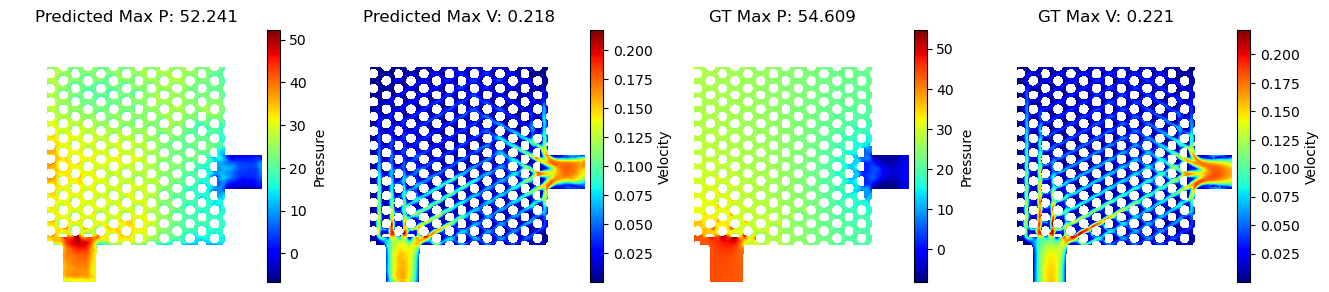

0
1000-bc_051_w_001_rn_001_inlet_top_outlet_right.npy


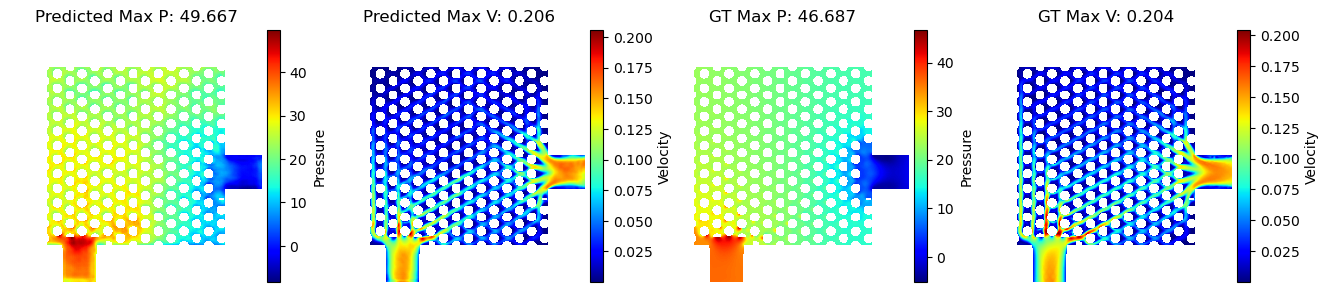

1
1000-bc_051_w_001_rn_002_inlet_top_outlet_right.npy


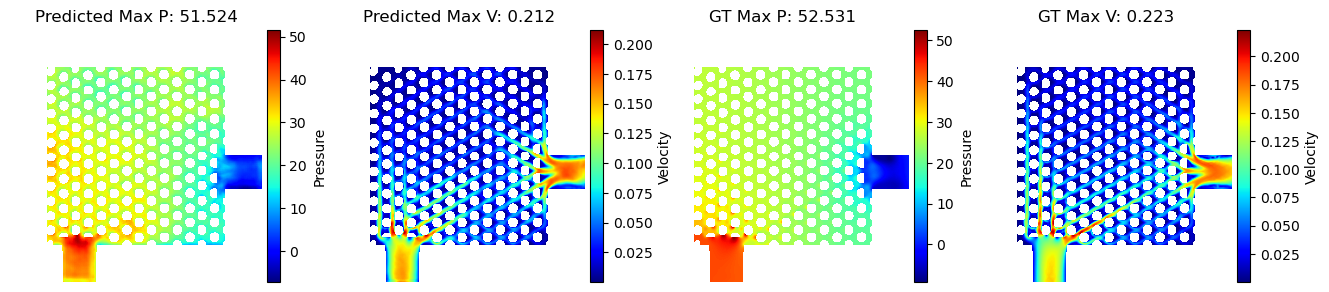

2
1000-bc_051_w_001_rn_003_inlet_top_outlet_right.npy


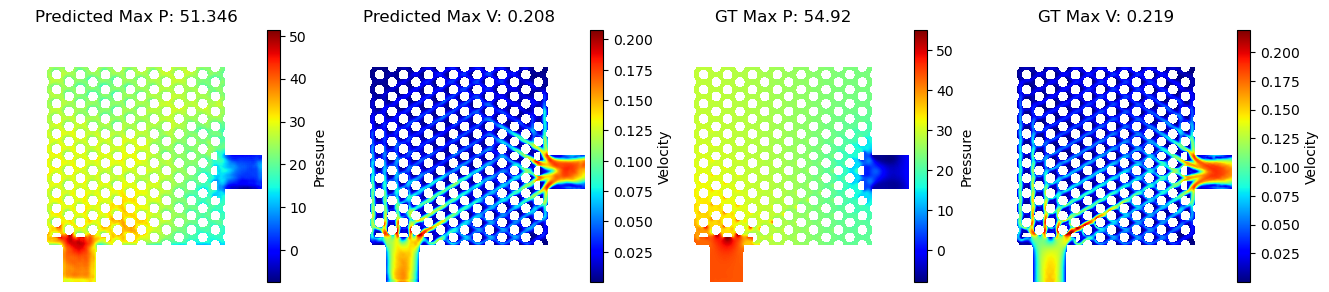

3
1000-bc_051_w_001_rn_004_inlet_top_outlet_right.npy


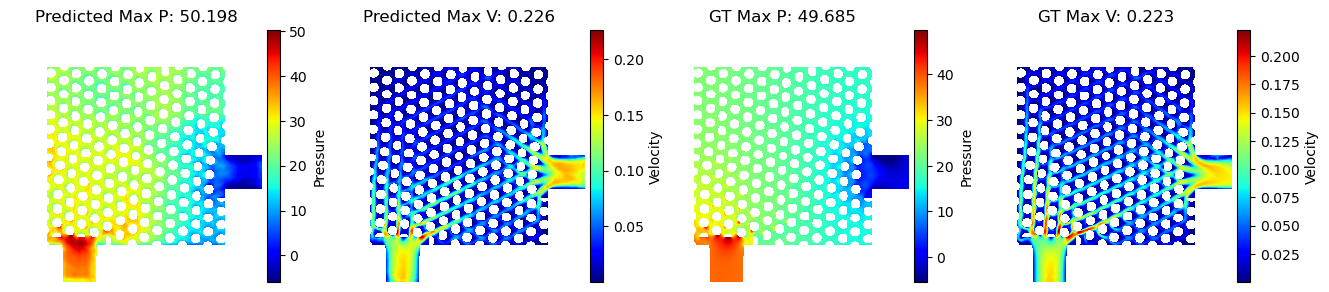

4
1000-bc_051_w_001_rn_005_inlet_top_outlet_right.npy


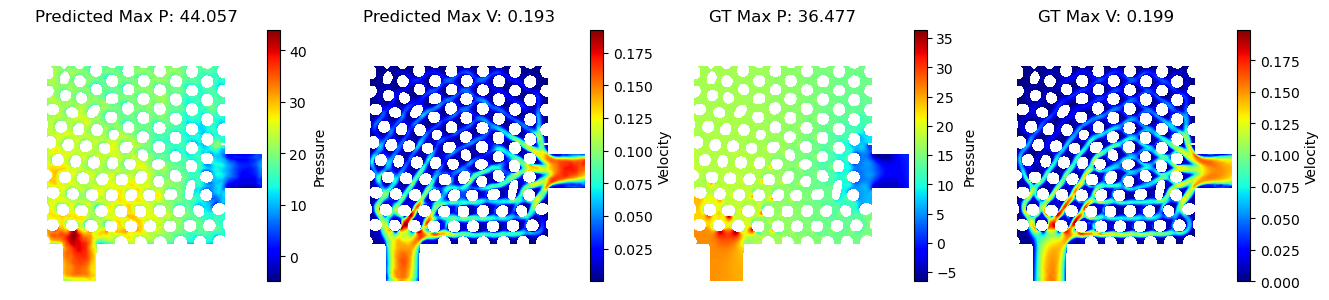

5
1000-bc_051_w_002_rn_001_inlet_top_outlet_right.npy


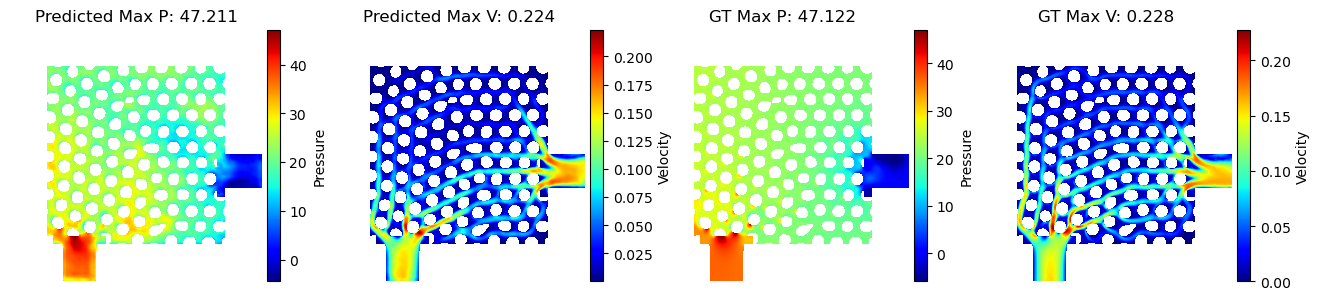

6
1000-bc_051_w_002_rn_002_inlet_top_outlet_right.npy


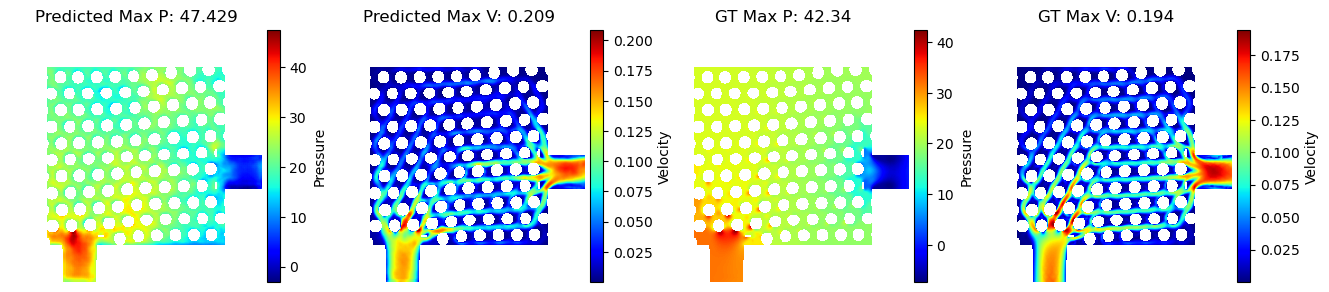

7
1000-bc_051_w_002_rn_003_inlet_top_outlet_right.npy


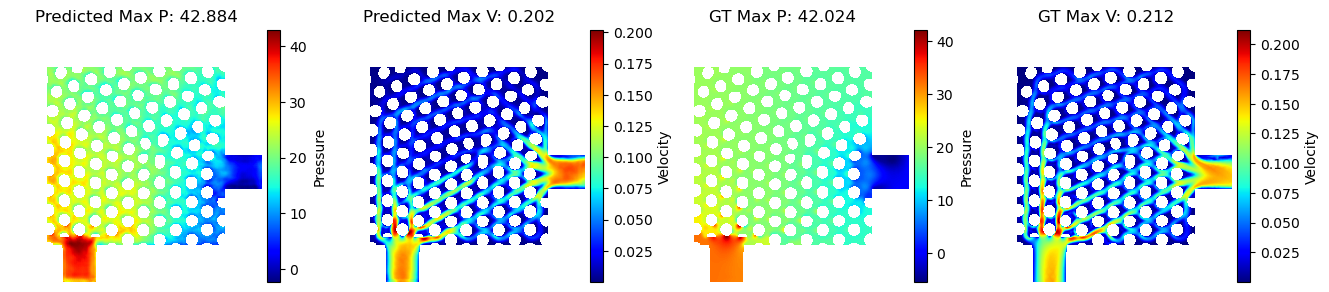

8
1000-bc_051_w_002_rn_004_inlet_top_outlet_right.npy


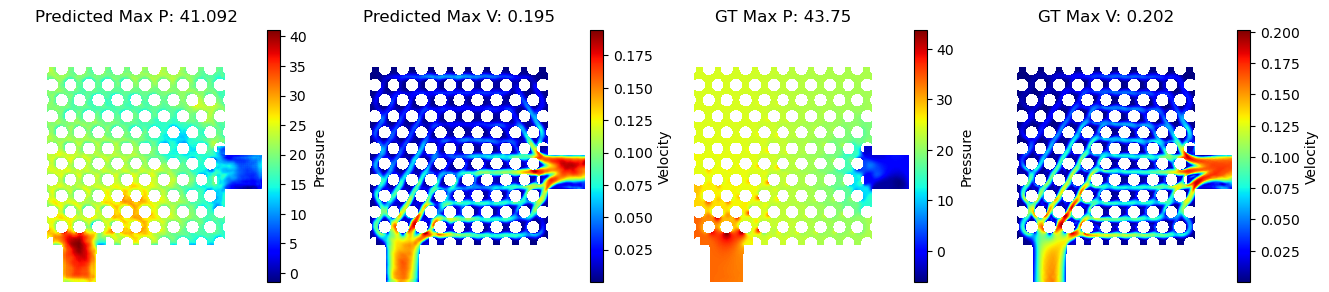

9
1000-bc_051_w_002_rn_005_inlet_top_outlet_right.npy


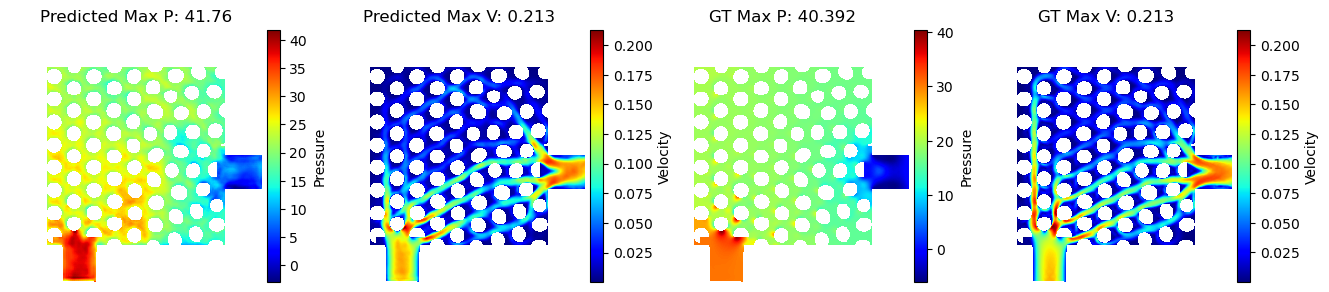

10
1000-bc_051_w_003_rn_001_inlet_top_outlet_right.npy


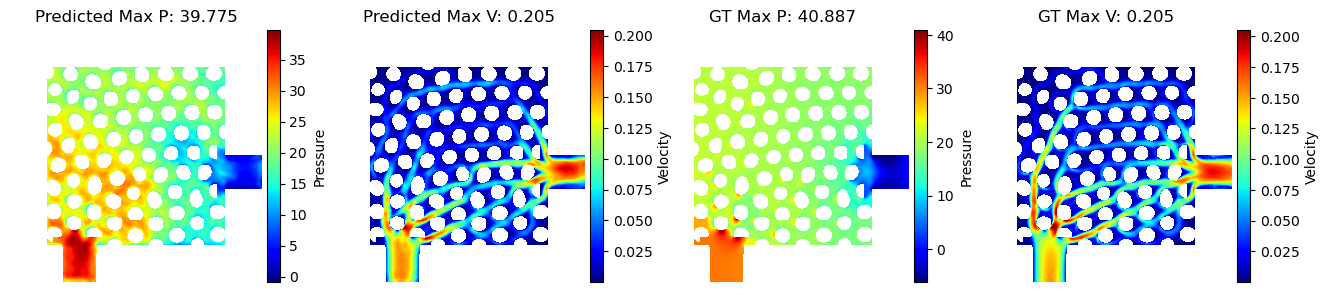

11
1000-bc_051_w_003_rn_002_inlet_top_outlet_right.npy


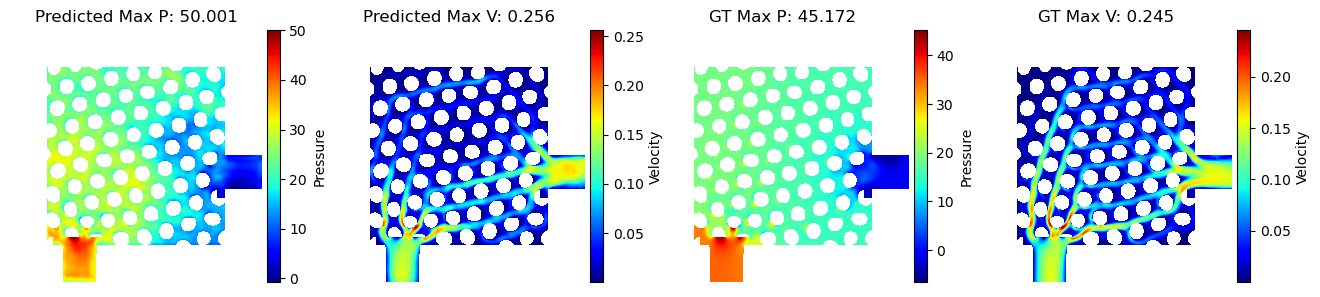

12
1000-bc_051_w_003_rn_003_inlet_top_outlet_right.npy


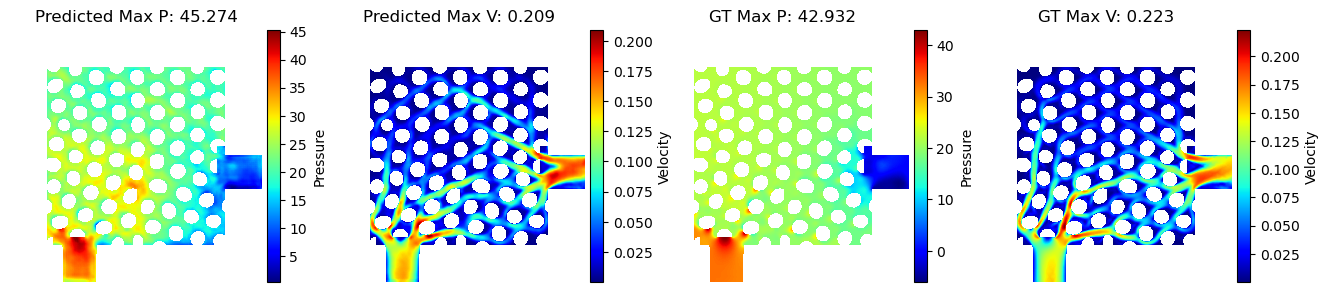

13
1000-bc_051_w_003_rn_004_inlet_top_outlet_right.npy


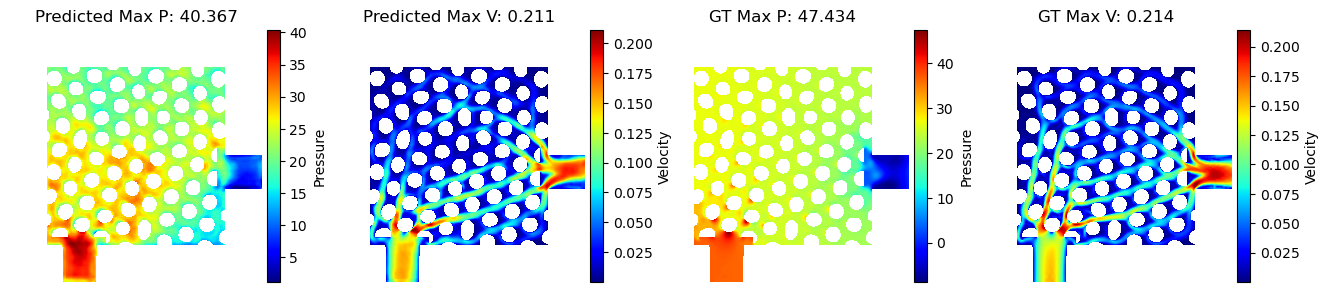

14
1000-bc_051_w_003_rn_005_inlet_top_outlet_right.npy


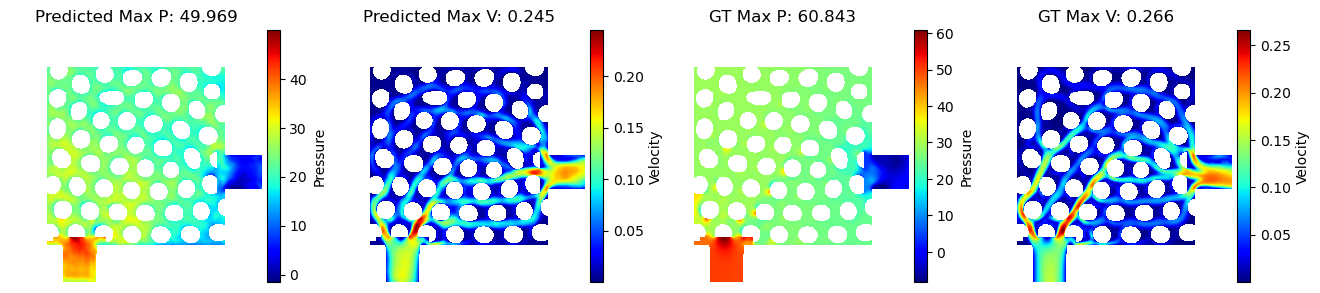

15
1000-bc_051_w_004_rn_001_inlet_top_outlet_right.npy


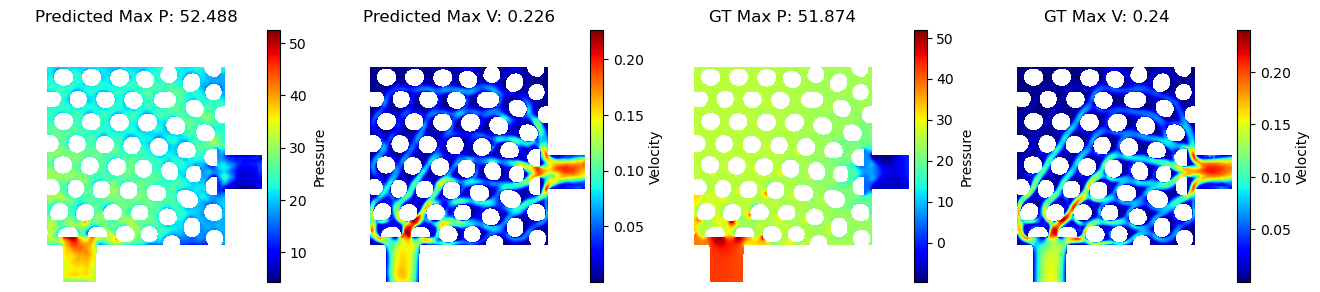

16
1000-bc_051_w_004_rn_002_inlet_top_outlet_right.npy


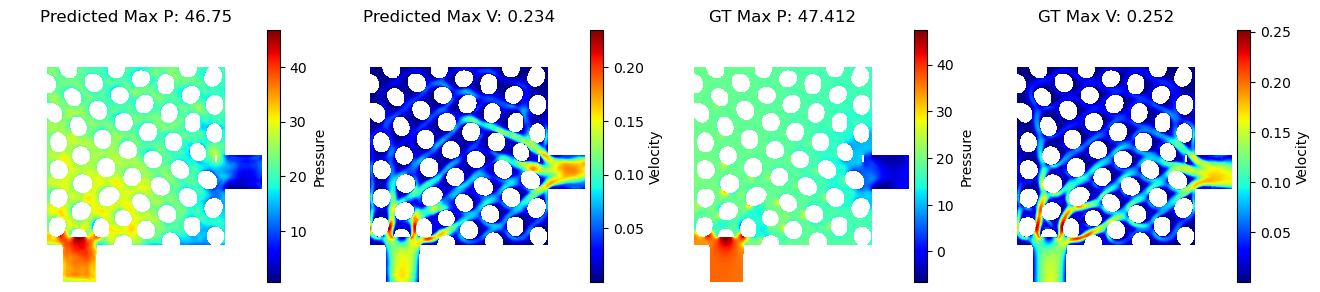

17
1000-bc_051_w_004_rn_003_inlet_top_outlet_right.npy


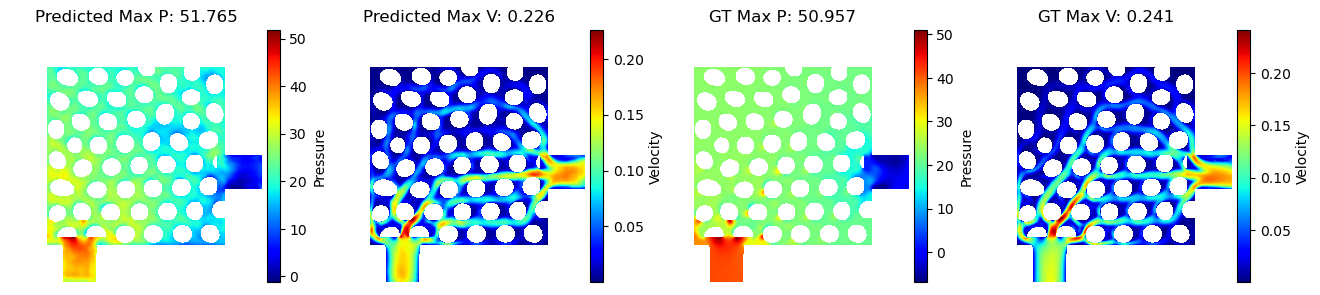

18
1000-bc_051_w_004_rn_004_inlet_top_outlet_right.npy


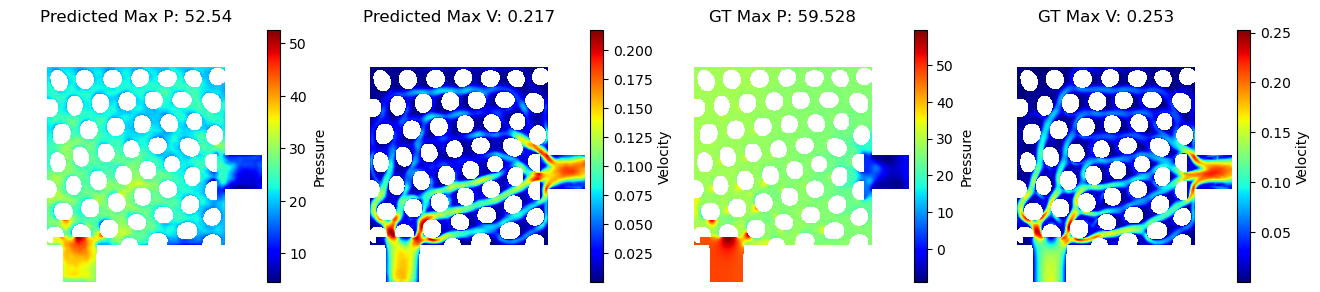

19
1000-bc_051_w_004_rn_005_inlet_top_outlet_right.npy


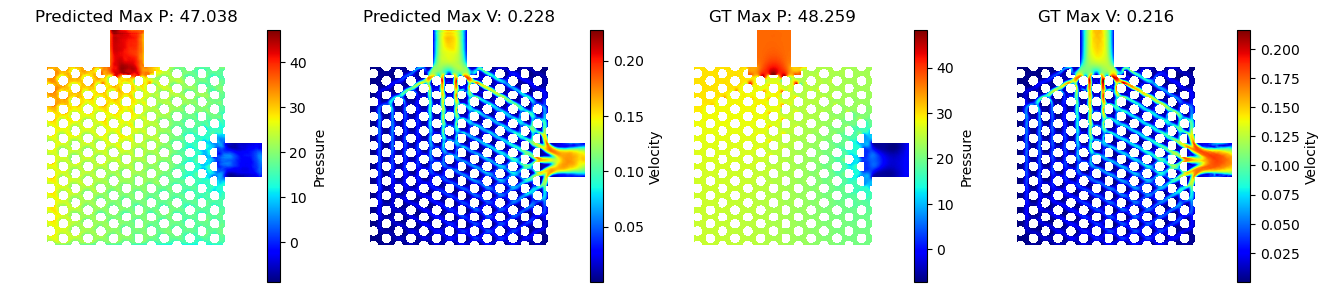

20
1000-bc_052_w_001_rn_001_inlet_bottom_outlet_right.npy


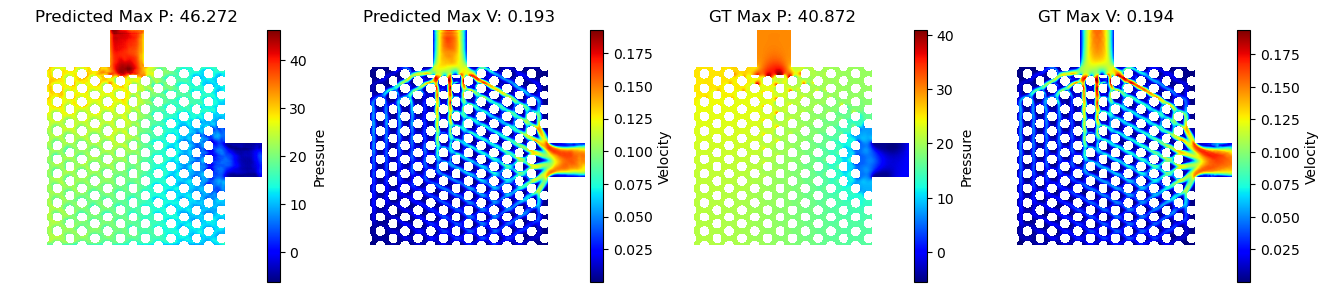

21
1000-bc_052_w_001_rn_002_inlet_bottom_outlet_right.npy


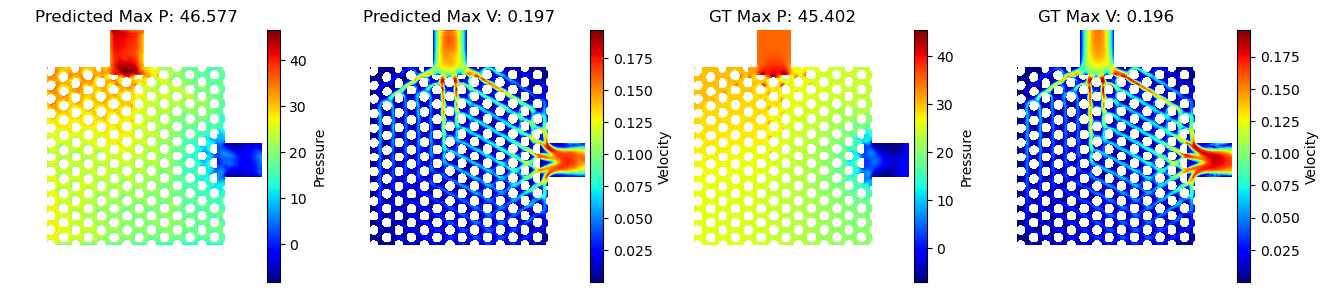

22
1000-bc_052_w_001_rn_003_inlet_bottom_outlet_right.npy


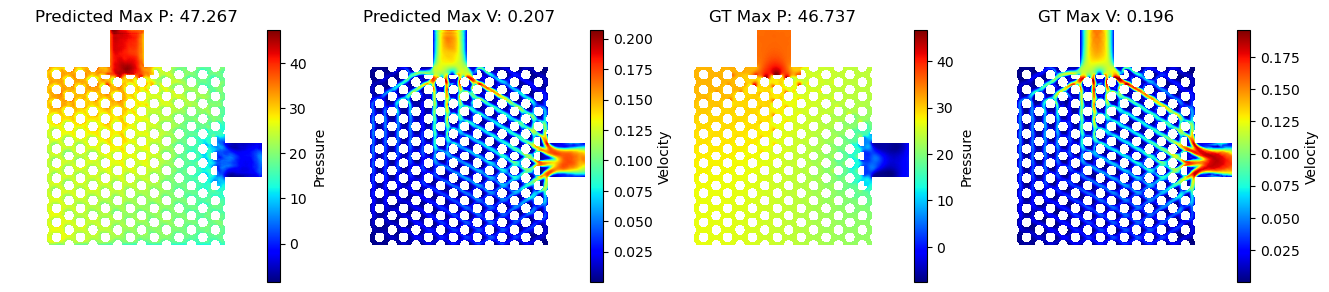

23
1000-bc_052_w_001_rn_004_inlet_bottom_outlet_right.npy


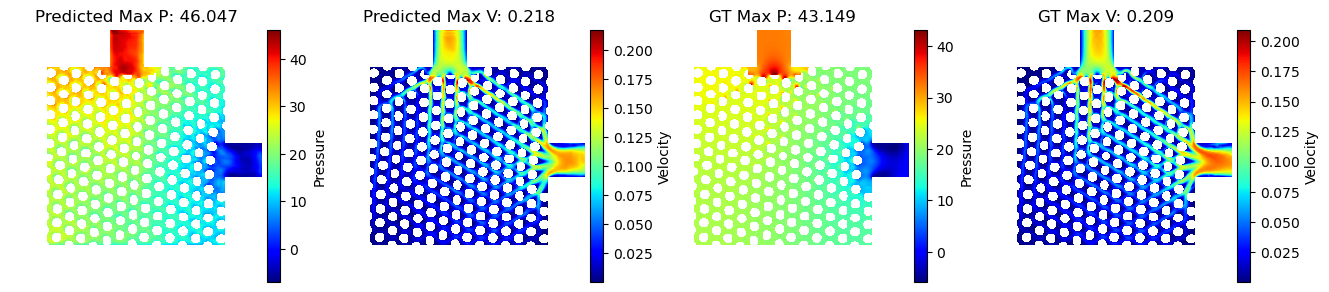

24
1000-bc_052_w_001_rn_005_inlet_bottom_outlet_right.npy


In [3]:
import matplotlib.pyplot as plt

lv2_folder = 'Validation/Low/LVV-new'
hv2_folder = 'Validation/High/HVV'
lp2_folder = 'Validation/Low/LPP-new'
hp2_folder = 'Validation/High/HPP'
lg2_folder = 'Validation/LG-3C'

# Get the list of file names in each folder
lv2_files = [f2 for f2 in os.listdir(lv2_folder) if f2 != ".ipynb_checkpoints"]
hv2_files = [f2 for f2 in os.listdir(hv2_folder) if f2 != ".ipynb_checkpoints"]
lp2_files = [f2 for f2 in os.listdir(lp2_folder) if f2 != ".ipynb_checkpoints"]
hp2_files = [f2 for f2 in os.listdir(hp2_folder) if f2 != ".ipynb_checkpoints"]
lg2_files = [f2 for f2 in os.listdir(lg2_folder) if f2 != ".ipynb_checkpoints"]

# Sort the file names to ensure the order is consistent
lv2_files.sort()
hv2_files.sort()
lp2_files.sort()
hp2_files.sort()
lg2_files.sort()



# Create empty lists to store the data
X_lv2 = []
X_lp2 = []
X_lg2 = []
Y_hv2 = []
Y_hp2 = []

# Read the data from the folders
for lv2_file, hv2_file,lp2_file,hp2_file,lg2_file in zip(lv2_files, hv2_files,lp2_files,hp2_files,lg2_files):
    try:
        
        # Read the LFV
        lv2_image = np.load(os.path.join(lv2_folder, lv2_file))  # Convert to RGB
        X_lv2.append(np.array(lv2_image))
        
        # Read the HFV
        hv2_image = np.load(os.path.join(hv2_folder, hv2_file))  # Convert to RGB
        Y_hv2.append(np.array(hv2_image))

        # Read the LFP
        lp2_image = np.load(os.path.join(lp2_folder, lp2_file))  # Convert to RGB
        X_lp2.append(np.array(lp2_image))
    
    
        # Read the channel geometry image
        lg2_image = Image.open(os.path.join(lg2_folder, lg2_file)).convert('RGB')  # Convert to RGB
        lg2_image = lg2_image.resize(input_shape[:2])  # Resize the image
        X_lg2.append(np.array(lg2_image))
    
        # Read the HFP
        hp2_image = np.load(os.path.join(hp2_folder, hp2_file))  # Convert to RGB
        Y_hp2.append(np.array(hp2_image))
    except:
        print('')

# Convert the lists to arrays
X_lv2 = np.array(X_lv2) 
X_lp2 = np.array(X_lp2) 
X_lg2 = np.array(X_lg2) / 255.0  # Normalize the channel geometry images
Y_hv2 = np.array(Y_hv2)
Y_hp2 = np.array(Y_hp2)





X_lp2 = np.nan_to_num(X_lp2, nan=0)
X_lv2 = np.nan_to_num(X_lv2, nan=0)
X_lp2=(X_lp2-np.min(X_lp2))/(np.max(X_lp2)-np.min(X_lp2))
# Predict velocity and pressure outputs
model.load_weights('Saved_Models_Temp/Micro-Unet-3-Inputs.h5')
pressure_output2,velocity_output2 = model.predict([X_lg2,X_lv2,X_lp2])

velocity_output2=(velocity_output2)
a=(np.max(Y_hp)-np.min(Y_hp))
b=(np.min(Y_hp))

pressure_output2=(pressure_output2*a)+b



mask = np.all(X_lg2 > 0.8, axis=-1)

# Expand mask to match the shape of array2
mask_expanded = np.repeat(mask[:, :, np.newaxis], 3, axis=2)
Y_hp2[mask]=np.nan
Y_hv2[mask]=np.nan
velocity_output2[mask]=np.nan
pressure_output2[mask]=np.nan

from mpl_toolkits.axes_grid1 import make_axes_locatable






def plot_images(index):
    plt.figure(figsize=(16, 48))

    # Display the pressure output
    ax1 = plt.subplot(1, 4, 1)
    im1 = ax1.imshow(pressure_output2[index],cmap='jet')
    divider1 = make_axes_locatable(ax1)
    cax1 = divider1.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im1, cax=cax1, label='Pressure')
    ax1.set_title('Predicted Max P: '+ str(np.round(np.nanmax(pressure_output2[index]),decimals=3)))
    ax1.axis("off")

    # Display the velocity output
    ax2 = plt.subplot(1, 4, 2)
    im2 = ax2.imshow(velocity_output2[index],cmap='jet')
    divider2 = make_axes_locatable(ax2)
    cax2 = divider2.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im2, cax=cax2, label='Velocity')
    ax2.set_title('Predicted Max V: '+ str(np.round(np.nanmax(velocity_output2[index]),decimals=3)))
    ax2.axis("off")

    # Display the input image (Pressure GT)
    ax3 = plt.subplot(1, 4, 3)
    im3 = ax3.imshow(Y_hp2[index],cmap='jet')
    divider3 = make_axes_locatable(ax3)
    cax3 = divider3.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im3, cax=cax3, label='Pressure')
    ax3.set_title('GT Max P: '+ str(np.round(np.nanmax(Y_hp2[index]),decimals=3)))
    ax3.axis("off")

    # Display the velocity GT
    ax4 = plt.subplot(1, 4, 4)
    im4 = ax4.imshow(Y_hv2[index],cmap='jet')
    divider4 = make_axes_locatable(ax4)
    cax4 = divider4.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im4, cax=cax4, label='Velocity')
    ax4.set_title('GT Max V: '+ str(np.round(np.nanmax(Y_hv2[index]),decimals=3)))
    ax4.axis("off")

    plt.show()

# Loop to plot images 
for i in range(0, 25):
    plot_images(i)
    print(i)
    print(lv2_files[i])

In [7]:
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import pearsonr
Yp = np.expand_dims(Y_hp2, axis=-1)
Yv = np.expand_dims(Y_hv2, axis=-1)

expected = Yp
predicted = pressure_output2

# Mean Squared Error (MSE)
mse = np.nanmean((expected - predicted) ** 2)

# Mean Absolute Error (MAE)
mae = np.nanmean(np.abs(expected - predicted))

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Coefficient of Determination (R^2)
ss_tot = np.nanmean((expected - np.nanmean(expected)) ** 2)
ss_res = np.nanmean((expected - predicted) ** 2)
r2 = 1 - (ss_res / ss_tot)

# Normalized Root Mean Squared Error (NRMSE)
nrmse = rmse / (np.nanmax(expected) - np.nanmin(expected))

# Relative Error (RE)
relative_error = np.abs(expected - predicted) / np.abs(expected)
re = np.nanmean(relative_error)

# Symmetric Mean Absolute Percentage Error (SMAPE)
smape = 100 * np.nanmean(2 * np.abs(expected - predicted) / (np.abs(expected) + np.abs(predicted)))

# Pearson Correlation Coefficient (r)
expected_flattened = expected.flatten()
predicted_flattened = predicted.flatten()
valid_mask = ~np.isnan(expected_flattened) & ~np.isnan(predicted_flattened)
expected_valid = expected_flattened[valid_mask]
predicted_valid = predicted_flattened[valid_mask]
pearson_corr = np.corrcoef(expected_valid, predicted_valid)[0, 1]



# Peak Signal-to-Noise Ratio (PSNR)
psnr = 10 * np.log10(np.nanmax(expected) ** 2 / mse)

# Print Results
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2: {r2:.4f}")
print(f"NRMSE: {nrmse:.4f}")
print(f"Relative Error: {re:.4f}")
print(f"SMAPE: {smape:.4f}%")
print(f"Pearson Correlation: {pearson_corr:.4f}")
print(f"PSNR: {psnr:.4f} dB")



MSE: 179.0490
MAE: 6.7049
RMSE: 13.3809
R^2: 0.6812
NRMSE: 0.0233
Relative Error: 2.8305
SMAPE: 40.5988%
Pearson Correlation: 0.8345
PSNR: 31.7793 dB


In [8]:
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import pearsonr

# Dummy data (replace with actual predicted and expected arrays)
expected = Yv
predicted = velocity_output2

# Mean Squared Error (MSE)
mse = np.nanmean((expected - predicted) ** 2)

# Mean Absolute Error (MAE)
mae = np.nanmean(np.abs(expected - predicted))

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Coefficient of Determination (R^2)
ss_tot = np.nanmean((expected - np.nanmean(expected)) ** 2)
ss_res = np.nanmean((expected - predicted) ** 2)
r2 = 1 - (ss_res / ss_tot)

# Normalized Root Mean Squared Error (NRMSE)
nrmse = rmse / (np.nanmax(expected) - np.nanmin(expected))

# Relative Error (RE)
relative_error = np.abs(expected - predicted) / np.abs(expected)
re = np.nanmean(relative_error)

# Symmetric Mean Absolute Percentage Error (SMAPE)
smape = 100 * np.nanmean(2 * np.abs(expected - predicted) / (np.abs(expected) + np.abs(predicted)))

# Pearson Correlation Coefficient (r)
expected_flattened = expected.flatten()
predicted_flattened = predicted.flatten()
valid_mask = ~np.isnan(expected_flattened) & ~np.isnan(predicted_flattened)
expected_valid = expected_flattened[valid_mask]
predicted_valid = predicted_flattened[valid_mask]
pearson_corr = np.corrcoef(expected_valid, predicted_valid)[0, 1]



# Peak Signal-to-Noise Ratio (PSNR)
psnr = 10 * np.log10(np.nanmax(expected) ** 2 / mse)

# Print Results
print(f"MSE: {mse:.8f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2: {r2:.4f}")
print(f"NRMSE: {nrmse:.4f}")
print(f"Relative Error: {re:.4f}")
print(f"SMAPE: {smape:.4f}%")
print(f"Pearson Correlation: {pearson_corr:.4f}")
print(f"PSNR: {psnr:.4f} dB")



MSE: 0.00048473
MAE: 0.0120
RMSE: 0.0220
R^2: 0.8393
NRMSE: 0.0241
Relative Error: 264777315.4955
SMAPE: 48.9528%
Pearson Correlation: 0.9171
PSNR: 32.3459 dB


In [9]:
path1="Results_Temp/Physics/Unet"
os.makedirs(path1, exist_ok=True)
np.save(path1+"/velocity_predicted.npy",velocity_output2)
np.save(path1+"/pressure_predicted.npy",pressure_output2)
